- 04_CDR_Exploratory_Analysis.ipynb
- Algerie Telecom CDR Exploratory Data Analysis
- Author: Data Engineering Team
- Date: July 2025

# 📡 CDR Exploratory Data Analysis

Deep dive into Call Detail Records patterns, usage behaviors, and network insights.

## Objectives:
- Analyze CDR patterns and distributions
- Understand usage behaviors by time and geography
- Identify peak usage patterns
- Explore anomalies and outages
- Generate insights for network optimization


## 1. Environment Setup

In [1]:
import sys
sys.path.append('/home/jovyan/work/batch/jupyter/notebooks/work/scripts')
from spark_init import init_spark
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import hashlib
from pyspark.sql import functions as F, types as T
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import *
from datetime import datetime
from datetime import datetime, timedelta

# Initialize Spark with proper configuration
spark = init_spark("EDA - Generated AT CDR")
print("✅ SparkSession initialized")
print(f"Spark Version: {spark.version}")
print(f"Warehouse Location: {spark.conf.get('spark.sql.warehouse.dir')}")


# Use the database
spark.sql("USE algerie_telecom_cdr")

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Environment ready for CDR analysis")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/08 03:04:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ SparkSession initialized (App: EDA - Generated AT CDR, Spark: 3.5.1)
✅ Hive Warehouse: hdfs://namenode:9000/user/hive/warehouse
✅ Hive Metastore URI: thrift://hive-metastore:9083
✅ SparkSession initialized
Spark Version: 3.5.1
Warehouse Location: hdfs://namenode:9000/user/hive/warehouse


25/07/08 03:04:06 WARN HiveConf: HiveConf of name hive.metastore.event.db.notification.api.auth does not exist


Environment ready for CDR analysis


In [2]:
cdr_raw = spark.read.parquet("/user/hive/warehouse/Raw/raw_cdr_enhanced/")
cdr_raw.createOrReplaceTempView("fact_cdr_raw")


25/07/08 03:04:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
spark.catalog.listTables()

[Table(name='cdr_anonymized', catalog='spark_catalog', namespace=['algerie_telecom_cdr'], description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='cdr_daily_summary', catalog='spark_catalog', namespace=['algerie_telecom_cdr'], description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='cdr_network_metrics', catalog='spark_catalog', namespace=['algerie_telecom_cdr'], description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='v_daily_trends', catalog='spark_catalog', namespace=['algerie_telecom_cdr'], description=None, tableType='VIEW', isTemporary=False),
 Table(name='v_network_performance', catalog='spark_catalog', namespace=['algerie_telecom_cdr'], description=None, tableType='VIEW', isTemporary=False),
 Table(name='data_quality_checks', catalog='spark_catalog', namespace=['algerie_telecom_cdr'], description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='cdr_hourly_aggregated', catalog='spark_catalog', namespace=['algerie_teleco

## 2. CDR Overview and Statistics
Get total CDR count and date range

📋 Schema of fact_cdr_raw:
root
 |-- cdr_id: string (nullable = true)
 |-- timestamp: timestamp_ntz (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- connection_id: string (nullable = true)
 |-- wilaya_code: string (nullable = true)
 |-- wilaya_name: string (nullable = true)
 |-- cdr_type: string (nullable = true)
 |-- service_type: string (nullable = true)
 |-- data_volume_mb: double (nullable = true)
 |-- duration_minutes: double (nullable = true)
 |-- session_quality: string (nullable = true)
 |-- usage_type: string (nullable = true)
 |-- offer_name: string (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- bandwidth_mbps: double (nullable = true)
 |-- anomaly_type: string (nullable = true)
 |-- severity: string (nullable = true)
 |-- old_offer: string (nullable = true)
 |-- new_offer: string (nullable = true)
 |-- old_price: double (nullable = true)
 |-- new_price: double (nullable = true)
 |-- change_reason: string (nullable = true)
 |-- data_cap_gb


📊 CDR Dataset Overview:
  • Total CDRs           : 768,359,379
  • Unique Customers     : 519,912
  • Date Range           : 2025-03-20 00:00:00 → 2025-07-19 23:59:59
  • Total Days Span      : 121
  • Active Calendar Days : 122
  • Avg CDRs per Active Day : 6,298,028


25/07/07 20:39:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/07 20:39:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/07 20:39:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/07 20:39:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/07 20:39:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/07 20:39:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


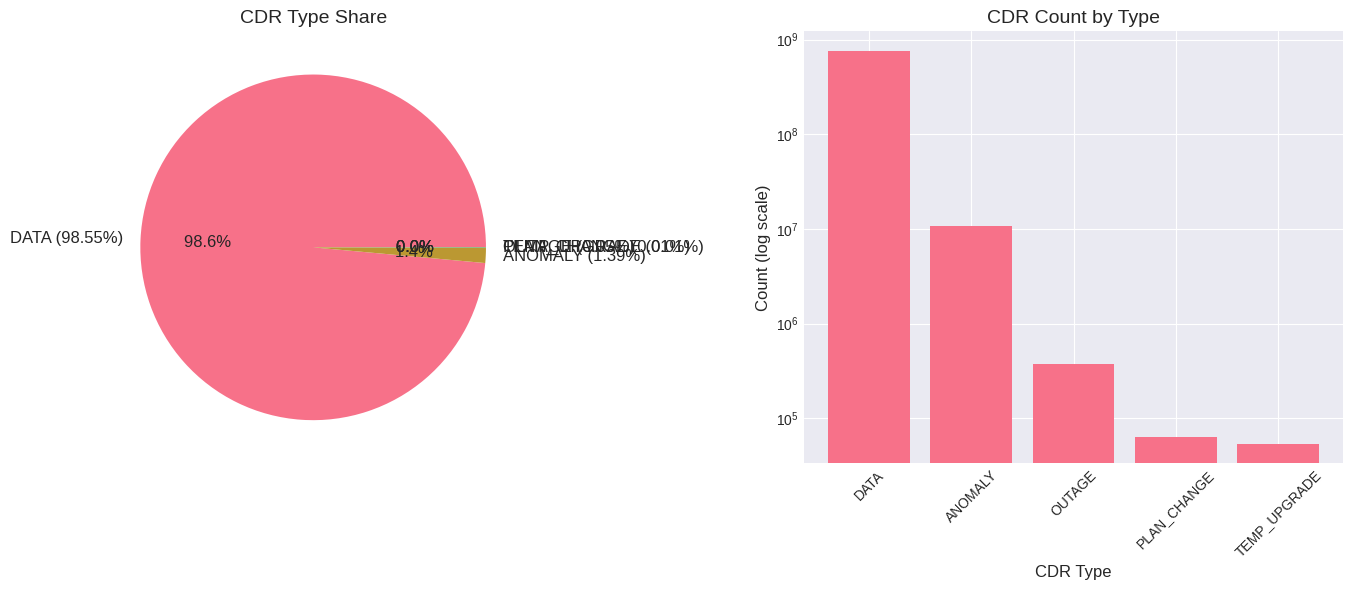

In [6]:
# ⏱ Final Survival-Mode CDR Overview & Type Breakdown

# 0) Inspect schema to confirm timestamp + customer_id fields
print("📋 Schema of fact_cdr_raw:")
cdr_raw.printSchema()

# ——————————————————————————————————————————————————————————————————————————————
# 1) Compute high-level stats in one go
stats = spark.sql("""
  SELECT
    COUNT(*)                                    AS total_cdrs,
    COUNT(DISTINCT customer_id)                 AS unique_customers,
    MIN(timestamp)                              AS first_record,
    MAX(timestamp)                              AS last_record,
    DATEDIFF(MAX(timestamp), MIN(timestamp))    AS total_days,
    COUNT(DISTINCT TO_DATE(timestamp))          AS active_days
  FROM fact_cdr_raw
""").collect()[0]

print("\n📊 CDR Dataset Overview:")
print(f"  • Total CDRs           : {stats['total_cdrs']:,}")
print(f"  • Unique Customers     : {stats['unique_customers']:,}")
print(f"  • Date Range           : {stats['first_record']} → {stats['last_record']}")
print(f"  • Total Days Span      : {stats['total_days']}")
print(f"  • Active Calendar Days : {stats['active_days']}")
print(f"  • Avg CDRs per Active Day : {stats['total_cdrs'] / stats['active_days']:,.0f}")

# ——————————————————————————————————————————————————————————————————————————————
# 2) Breakdown by CDR type
cdr_types = spark.sql("""
  SELECT
    cdr_type,
    COUNT(*)                           AS cnt,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS pct
  FROM fact_cdr_raw
  GROUP BY cdr_type
  ORDER BY cnt DESC
""").toPandas()

# ——————————————————————————————————————————————————————————————————————————————
# 3) Plot distribution
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
ax1.pie(
    cdr_types['cnt'],
    labels=[f"{t} ({p}%)" for t, p in zip(cdr_types['cdr_type'], cdr_types['pct'])],
    autopct=lambda pct: f"{pct:.1f}% ",
    textprops={'fontsize':12}
)
ax1.set_title('CDR Type Share', fontsize=14)

# Log-scale bar chart
ax2.bar(cdr_types['cdr_type'], cdr_types['cnt'])
ax2.set_yscale('log')
ax2.set_xlabel('CDR Type', fontsize=12)
ax2.set_ylabel('Count (log scale)', fontsize=12)
ax2.set_title('CDR Count by Type', fontsize=14)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 3. Temporal Analysis - Usage Patterns
Daily CDR volume trend

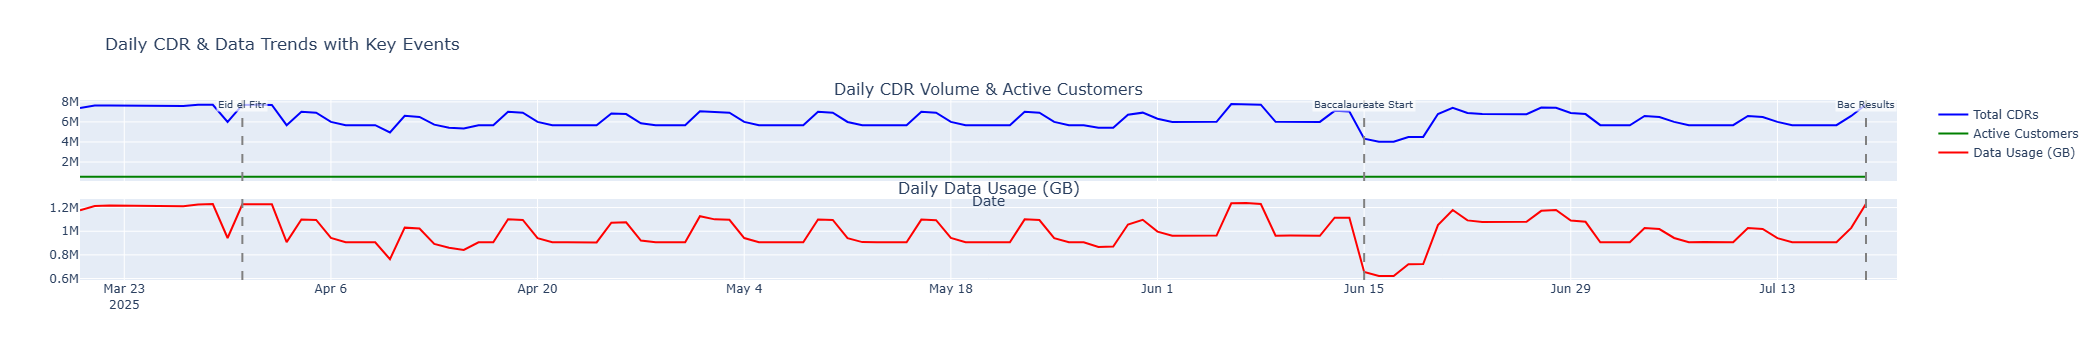

In [9]:
# ⏱ 3. Temporal Analysis – Daily Trends & Special Events (fixed)

# 1) Compute daily aggregates in one go
daily_trend = spark.sql("""
  SELECT
    DATE(timestamp)                     AS date,
    COUNT(*)                           AS total_cdrs,
    SUM(CASE WHEN cdr_type = 'DATA' THEN 1 ELSE 0 END)                           AS data_cdrs,
    ROUND(SUM(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE 0 END) / 1024, 2) AS data_gb,
    COUNT(DISTINCT customer_id)         AS active_customers
  FROM fact_cdr_raw
  GROUP BY DATE(timestamp)
  ORDER BY date
""").toPandas()

# 2) Build interactive Plotly chart
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=("Daily CDR Volume & Active Customers", "Daily Data Usage (GB)")
)

# Top panel: CDRs + Customers
fig.add_trace(
    go.Scatter(x=daily_trend['date'], y=daily_trend['total_cdrs'],
               name='Total CDRs', line=dict(color='blue')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=daily_trend['date'], y=daily_trend['active_customers'],
               name='Active Customers', line=dict(color='green')),
    row=1, col=1
)

# Bottom panel: Data usage
fig.add_trace(
    go.Scatter(x=daily_trend['date'], y=daily_trend['data_gb'],
               name='Data Usage (GB)', line=dict(color='red')),
    row=2, col=1
)

# Annotate special dates (convert to datetime!)
special_events = [
    {'date': '2025-03-31', 'event': 'Eid el Fitr'},
    {'date': '2025-06-15', 'event': 'Baccalaureate Start'},
    {'date': '2025-07-19', 'event': 'Bac Results'}
]

for ev in special_events:
    ev_dt = pd.to_datetime(ev['date'])  # <-- convert from str to Timestamp
    # draw the vertical line
    fig.add_vline(x=ev_dt, line_dash="dash", line_color="gray")
    # place annotation at top of plot area
    fig.add_annotation(
        x=ev_dt, y=1.02, xref='x', yref='paper',
        text=ev['event'], showarrow=False,
        bgcolor='rgba(255,255,255,0.7)', 
        font=dict(size=10),
        align='center',
    )

fig.update_layout(
    height=700,
    title_text="Daily CDR & Data Trends with Key Events",
    xaxis_title="Date"
)
fig.show()


## 4. Hourly Usage Patterns
Hourly patterns analytics

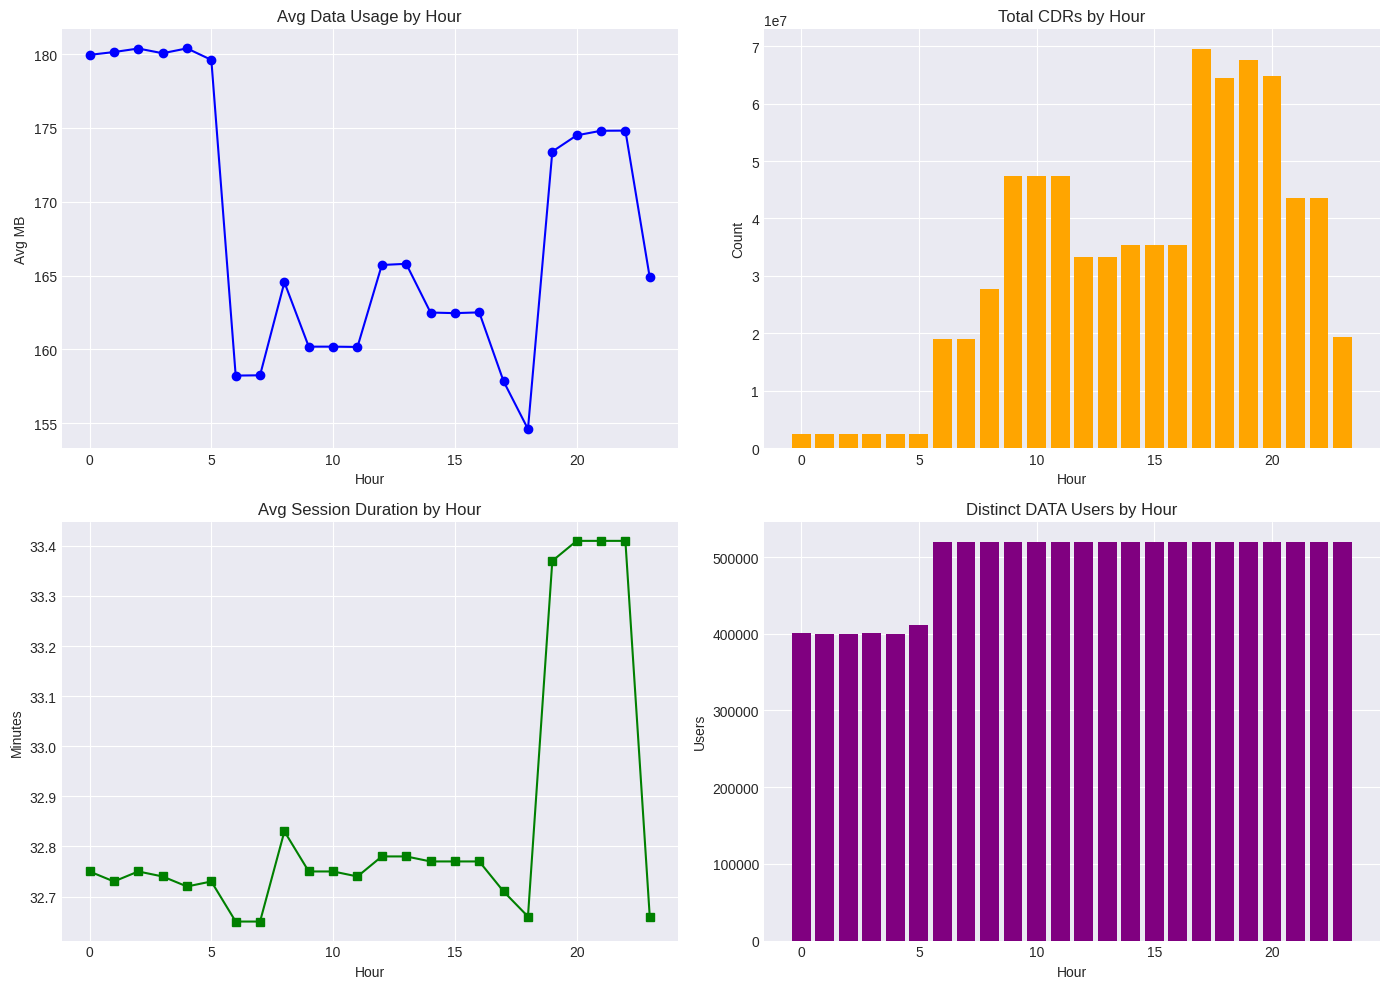


🔝 Peak Data Hours:
  Hour 04:00 — Avg 180.39 MB | Users: 400139.0
  Hour 02:00 — Avg 180.38 MB | Users: 399979.0
  Hour 01:00 — Avg 180.14 MB | Users: 400250.0
  Hour 03:00 — Avg 180.06 MB | Users: 400376.0
  Hour 00:00 — Avg 179.95 MB | Users: 400361.0


In [8]:
# ⏱ 4. Hourly Data Usage Patterns (DATA only)

# 1) Hourly stats for DATA sessions
hourly_patterns = spark.sql("""
  SELECT
    HOUR(timestamp)                                     AS hour,
    ROUND(AVG(CASE WHEN cdr_type='DATA' THEN data_volume_mb ELSE NULL END),2)     AS avg_data_mb,
    COUNT(*)                                            AS total_cdrs,
    ROUND(AVG(CASE WHEN cdr_type='DATA' THEN duration_minutes ELSE NULL END),2)    AS avg_duration,
    COUNT(DISTINCT CASE WHEN cdr_type='DATA' THEN customer_id END)                 AS unique_users
  FROM fact_cdr_raw
  GROUP BY HOUR(timestamp)
  ORDER BY hour
""").toPandas()

# 2) Plot with Matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(14,10))

# a) Avg data MB
axs[0,0].plot(hourly_patterns['hour'], hourly_patterns['avg_data_mb'], 'b-o')
axs[0,0].set(title='Avg Data Usage by Hour', xlabel='Hour', ylabel='Avg MB')

# b) CDR Count
axs[0,1].bar(hourly_patterns['hour'], hourly_patterns['total_cdrs'], color='orange')
axs[0,1].set(title='Total CDRs by Hour', xlabel='Hour', ylabel='Count')

# c) Avg Duration
axs[1,0].plot(hourly_patterns['hour'], hourly_patterns['avg_duration'], 'g-s')
axs[1,0].set(title='Avg Session Duration by Hour', xlabel='Hour', ylabel='Minutes')

# d) Unique Users
axs[1,1].bar(hourly_patterns['hour'], hourly_patterns['unique_users'], color='purple')
axs[1,1].set(title='Distinct DATA Users by Hour', xlabel='Hour', ylabel='Users')

plt.tight_layout()
plt.show()

# 3) Top 5 peak hours by data
peaks = hourly_patterns.nlargest(5, 'avg_data_mb')
print("\n🔝 Peak Data Hours:")
for _,r in peaks.iterrows():
    print(f"  Hour {int(r.hour):02d}:00 — Avg {r.avg_data_mb:.2f} MB | Users: {r.unique_users}")


## 5. Geographic Usage Analysis
Geographic distribution of CDRs

📊 Running temporal analysis...


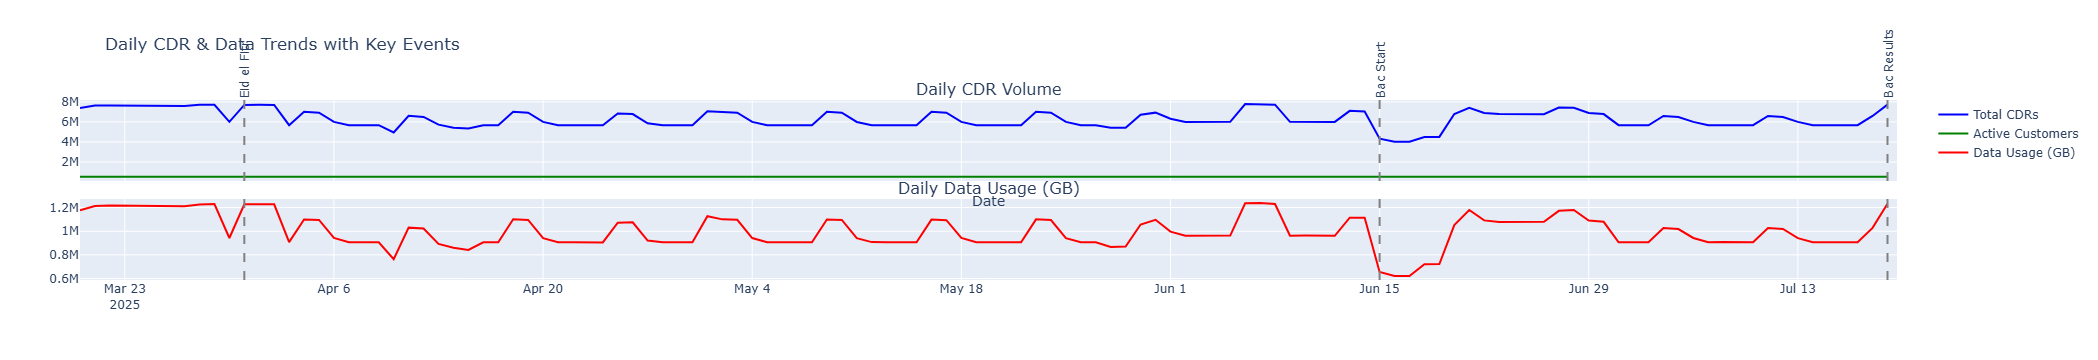


📊 Daily Trend Summary:
Total Days: 122
Total CDRs: 768,359,379
Total Data: 121,903,652.10 GB
Avg Daily CDRs: 6,298,028
Peak Day: 2025-06-06

⏰ Analyzing hourly patterns...


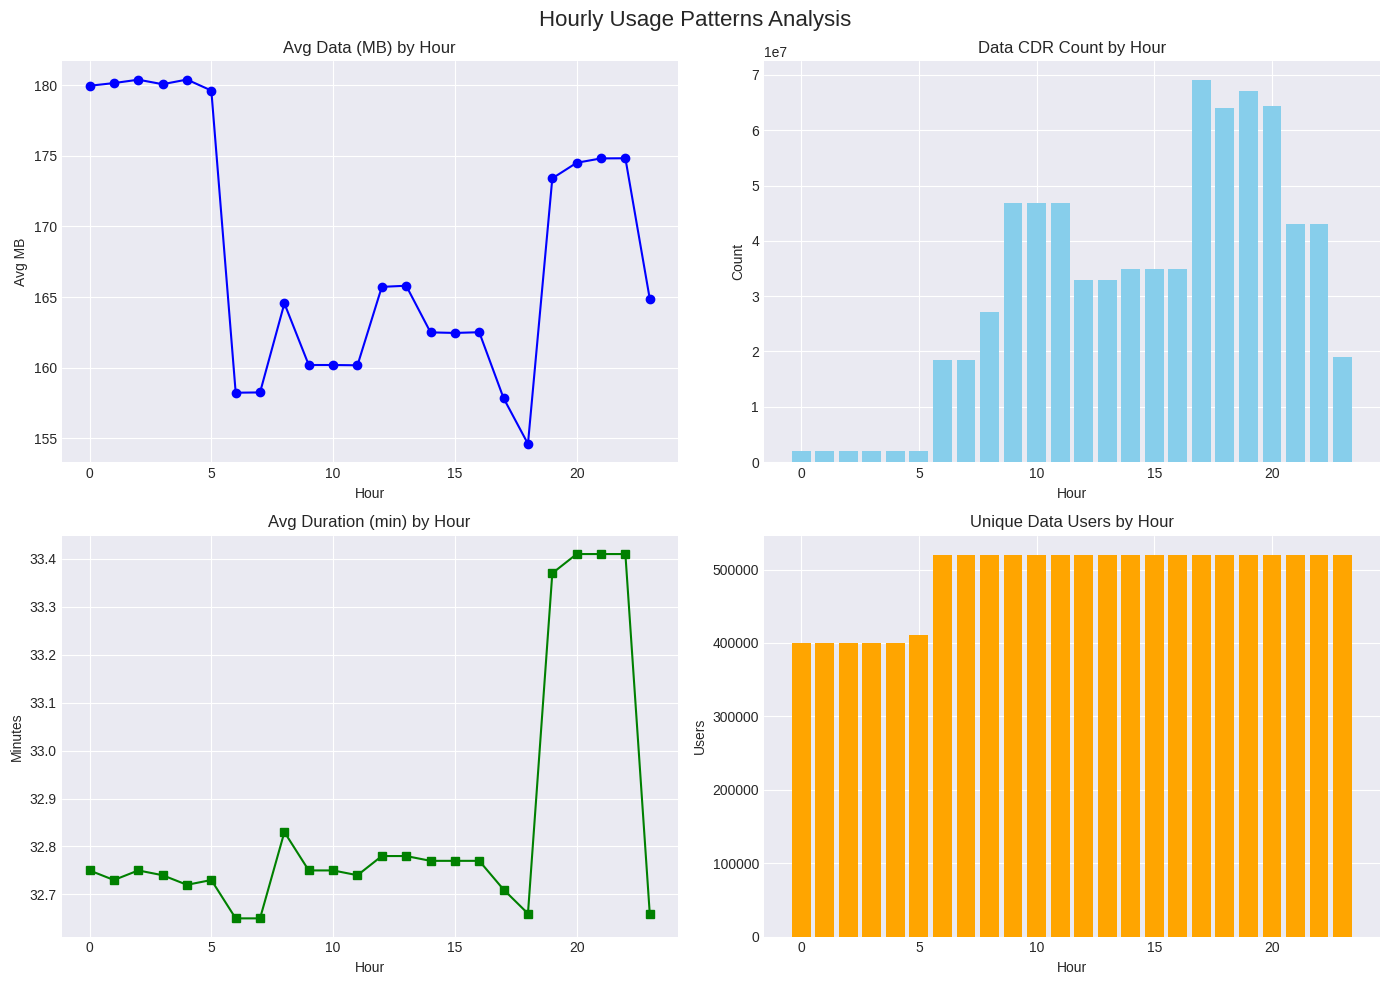


🔝 Top 5 Peak Usage Hours:
  Hour 04:00 → 180.4 MB avg, 400,139 users
  Hour 02:00 → 180.4 MB avg, 399,979 users
  Hour 01:00 → 180.1 MB avg, 400,250 users
  Hour 03:00 → 180.1 MB avg, 400,376 users
  Hour 00:00 → 179.9 MB avg, 400,361 users

🌍 Analyzing geographic distribution...


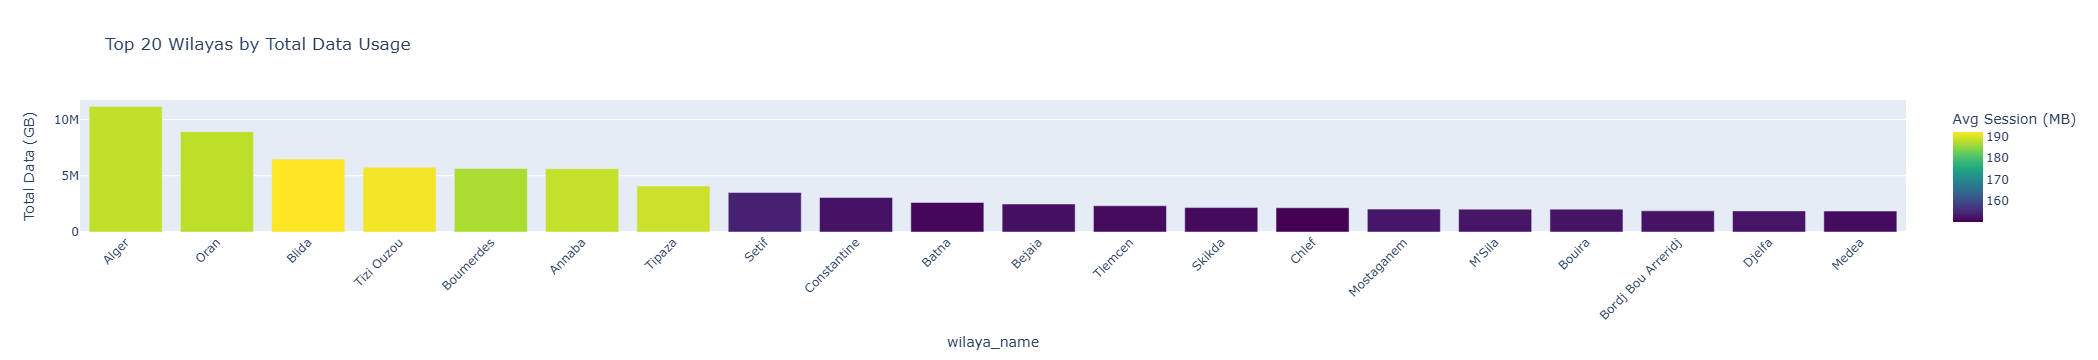


🏆 Top 5 Wilayas by Data Usage:
1. Alger: 11,141,864.70 GB (28,732 customers)
2. Oran: 8,911,460.64 GB (22,995 customers)
3. Blida: 6,480,433.61 GB (15,603 customers)
4. Tizi Ouzou: 5,743,145.00 GB (14,802 customers)
5. Boumerdes: 5,640,923.93 GB (13,966 customers)

📱 Analyzing service types...


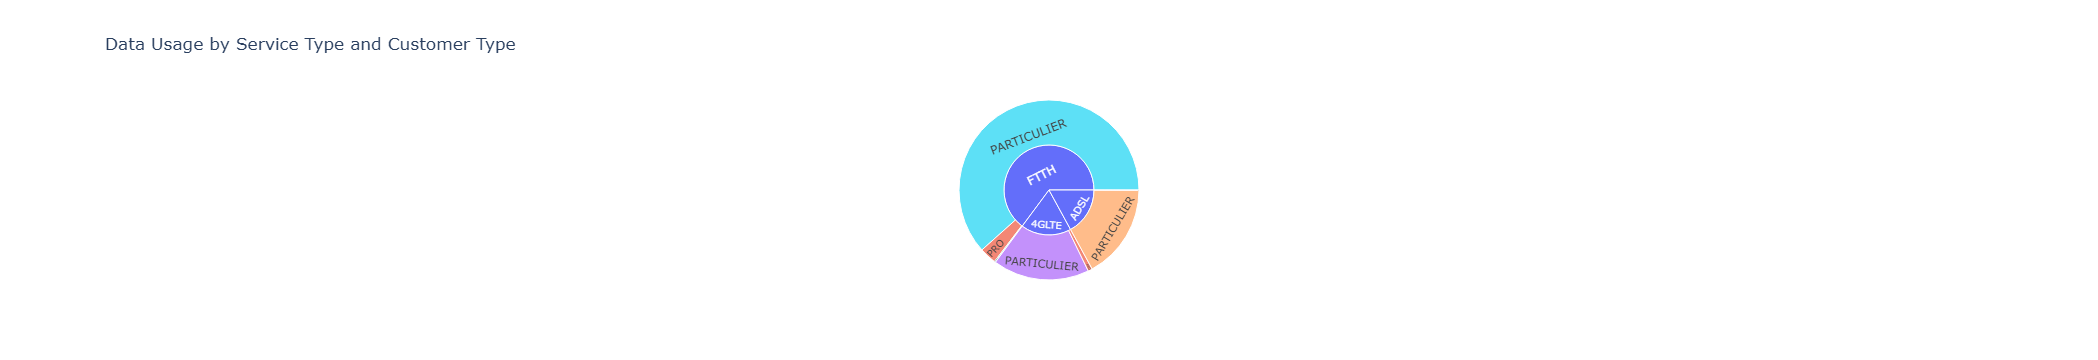


📱 Service Type Summary:
FTTH: 79,060,374.27 GB, 239,030 customers
4GLTE: 22,069,808.69 GB, 103,700 customers
ADSL: 20,773,469.16 GB, 177,184 customers

🚨 Analyzing anomalies...


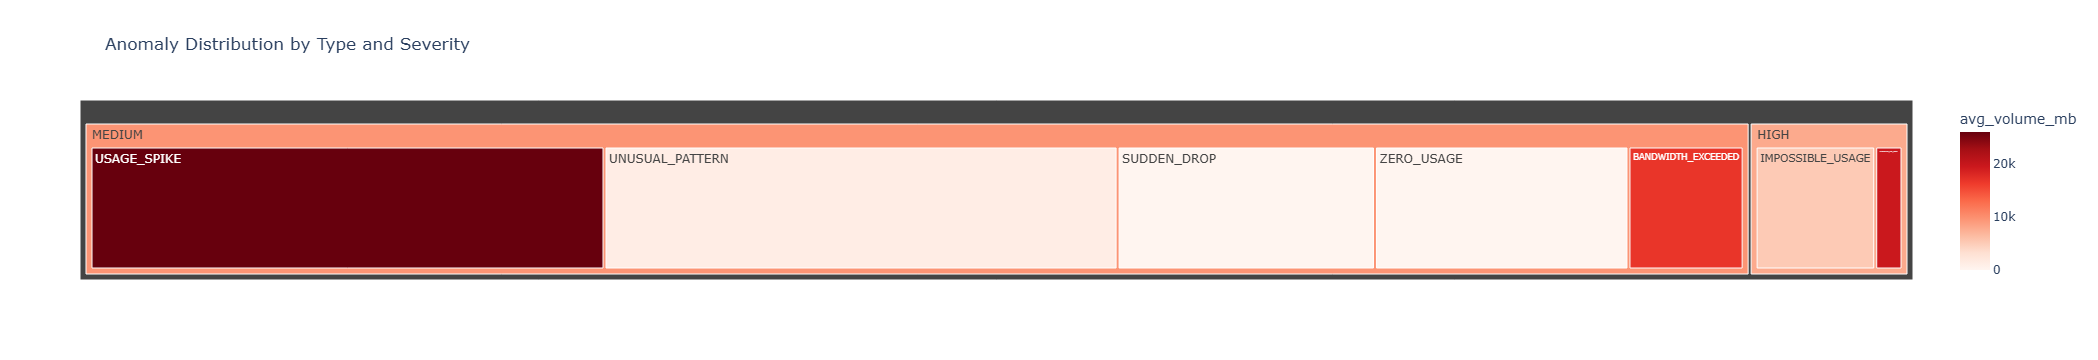


⚠️ Anomaly Summary:
Total Anomalies: 10,646,236
Affected Customers: 2,548,246

Top Anomaly Types:
- USAGE_SPIKE (MEDIUM): 3,022,021 cases
- UNUSUAL_PATTERN (MEDIUM): 3,016,426 cases
- SUDDEN_DROP (MEDIUM): 1,513,044 cases
- ZERO_USAGE (MEDIUM): 1,490,491 cases
- IMPOSSIBLE_USAGE (HIGH): 755,002 cases

✅ Analysis Complete!
Total execution time: 2025-07-07 21:16:41.753176


In [29]:
# ⏱ Final Survival-Mode CDR Analysis Cell (Completely Fixed)

# 0) Imports & setup
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyspark.sql import functions as F
import pandas as pd
from datetime import datetime

# Ensure temp view exists
if 'fact_cdr_raw' not in [t.name for t in spark.catalog.listTables()]:
    print("Creating fact_cdr_raw temp view...")
    cdr_raw = spark.read.parquet("/user/hive/warehouse/Raw/raw_cdr_enhanced/")
    cdr_raw.createOrReplaceTempView("fact_cdr_raw")
    print("✅ fact_cdr_raw temp view created")

# 1) Temporal Analysis — Daily CDR & Data Trends
print("📊 Running temporal analysis...")
daily_trend = spark.sql("""
    SELECT
      DATE(timestamp) AS date,
      COUNT(*)                                               AS total_cdrs,
      SUM(CASE WHEN cdr_type='DATA' THEN 1 ELSE 0 END)       AS data_cdrs,
      ROUND(SUM(CASE WHEN cdr_type='DATA' THEN data_volume_mb ELSE 0 END)/1024,2) AS data_gb,
      COUNT(DISTINCT customer_id)                            AS active_customers
    FROM fact_cdr_raw
    GROUP BY DATE(timestamp)
    ORDER BY date
""").toPandas()

# Convert date column to datetime
daily_trend['date'] = pd.to_datetime(daily_trend['date'])

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Daily CDR Volume', 'Daily Data Usage (GB)'),
    shared_xaxes=True,
    vertical_spacing=0.10
)

fig.add_trace(
    go.Scatter(x=daily_trend['date'], y=daily_trend['total_cdrs'],
               name='Total CDRs', line=dict(color='blue')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=daily_trend['date'], y=daily_trend['active_customers'],
               name='Active Customers', line=dict(color='green')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=daily_trend['date'], y=daily_trend['data_gb'],
               name='Data Usage (GB)', line=dict(color='red')),
    row=2, col=1
)

# Fixed: Convert string dates to datetime objects
events = [
    (datetime(2025, 3, 31), 'Eid el Fitr'),
    (datetime(2025, 6, 15), 'Bac Start'),
    (datetime(2025, 7, 19), 'Bac Results')
]

for dt, label in events:
    fig.add_vline(x=dt, line_dash="dash", line_color="gray")
    fig.add_annotation(x=dt, y=1, yref="paper", 
                      text=label, showarrow=False, 
                      textangle=-90, yanchor="bottom")

fig.update_layout(
    height=700,
    title_text="Daily CDR & Data Trends with Key Events",
    xaxis_title="Date"
)
fig.show()

# Print summary stats
print("\n📊 Daily Trend Summary:")
print(f"Total Days: {len(daily_trend)}")
print(f"Total CDRs: {daily_trend['total_cdrs'].sum():,}")
print(f"Total Data: {daily_trend['data_gb'].sum():,.2f} GB")
print(f"Avg Daily CDRs: {daily_trend['total_cdrs'].mean():,.0f}")
print(f"Peak Day: {daily_trend.loc[daily_trend['total_cdrs'].idxmax(), 'date'].strftime('%Y-%m-%d')}")

# 2) Hourly Usage Patterns — Data Sessions Only
print("\n⏰ Analyzing hourly patterns...")
hourly = spark.sql("""
    SELECT
      HOUR(timestamp) AS hour,
      ROUND(AVG(CASE WHEN cdr_type='DATA' THEN data_volume_mb ELSE 0 END),2)    AS avg_data_mb,
      COUNT(*)                                                              AS cdr_count,
      ROUND(AVG(CASE WHEN cdr_type='DATA' THEN duration_minutes ELSE 0 END),2) AS avg_duration,
      COUNT(DISTINCT customer_id)                                           AS unique_users
    FROM fact_cdr_raw
    WHERE cdr_type='DATA'
    GROUP BY HOUR(timestamp)
    ORDER BY hour
""").toPandas()

fig, axes = plt.subplots(2, 2, figsize=(14,10))

# Avg data / hr
axes[0,0].plot(hourly['hour'], hourly['avg_data_mb'], 'b-o')
axes[0,0].set(title='Avg Data (MB) by Hour', xlabel='Hour', ylabel='Avg MB')
axes[0,0].grid(True)

# CDR count / hr
axes[0,1].bar(hourly['hour'], hourly['cdr_count'], color='skyblue')
axes[0,1].set(title='Data CDR Count by Hour', xlabel='Hour', ylabel='Count')

# Avg session duration
axes[1,0].plot(hourly['hour'], hourly['avg_duration'], 'g-s')
axes[1,0].set(title='Avg Duration (min) by Hour', xlabel='Hour', ylabel='Minutes')
axes[1,0].grid(True)

# Unique users / hr
axes[1,1].bar(hourly['hour'], hourly['unique_users'], color='orange')
axes[1,1].set(title='Unique Data Users by Hour', xlabel='Hour', ylabel='Users')

plt.suptitle('Hourly Usage Patterns Analysis', fontsize=16)
plt.tight_layout()
plt.show()

# Peak hours analysis
top5 = hourly.nlargest(5, 'avg_data_mb')
print("\n🔝 Top 5 Peak Usage Hours:")
for _, r in top5.iterrows():
    print(f"  Hour {int(r['hour']):02d}:00 → {r['avg_data_mb']:.1f} MB avg, {int(r['unique_users']):,} users")

# 3) Geographic Analysis
print("\n🌍 Analyzing geographic distribution...")
geo = spark.sql("""
    SELECT
      wilaya_name,
      wilaya_code,
      COUNT(*)                                             AS total_cdrs,
      COUNT(DISTINCT customer_id)                          AS unique_customers,
      ROUND(SUM(CASE WHEN cdr_type='DATA' THEN data_volume_mb ELSE 0 END)/1024,2) AS total_data_gb,
      ROUND(AVG(CASE WHEN cdr_type='DATA' THEN data_volume_mb ELSE NULL END),2)    AS avg_session_mb,
      SUM(CASE WHEN cdr_type='ANOMALY' THEN 1 ELSE 0 END)   AS anomaly_count,
      SUM(CASE WHEN cdr_type='OUTAGE' THEN 1 ELSE 0 END)    AS outage_count
    FROM fact_cdr_raw
    GROUP BY wilaya_name, wilaya_code
    ORDER BY total_data_gb DESC
    LIMIT 20
""").toPandas()

# Geographic bar chart
fig = px.bar(
    geo,
    x='wilaya_name', 
    y='total_data_gb',
    color='avg_session_mb',
    title='Top 20 Wilayas by Total Data Usage',
    labels={'total_data_gb':'Total Data (GB)', 'avg_session_mb':'Avg Session (MB)'},
    hover_data=['unique_customers', 'anomaly_count', 'outage_count'],
    color_continuous_scale='viridis'
)
fig.update_layout(xaxis_tickangle=-45, height=600)
fig.show()

# Print top 5 wilayas
print("\n🏆 Top 5 Wilayas by Data Usage:")
for idx, row in geo.head().iterrows():
    print(f"{idx+1}. {row['wilaya_name']}: {row['total_data_gb']:,.2f} GB ({row['unique_customers']:,} customers)")

# 4) Service Type Analysis
print("\n📱 Analyzing service types...")
service_analysis = spark.sql("""
    SELECT
      service_type,
      customer_type,
      COUNT(DISTINCT customer_id) as customers,
      COUNT(*) as total_cdrs,
      ROUND(SUM(CASE WHEN cdr_type='DATA' THEN data_volume_mb ELSE 0 END)/1024, 2) as data_gb,
      ROUND(100.0 * SUM(CASE WHEN cdr_type='ANOMALY' THEN 1 ELSE 0 END)/COUNT(*), 2) as anomaly_pct
    FROM fact_cdr_raw
    GROUP BY service_type, customer_type
    ORDER BY data_gb DESC
""").toPandas()

# Service type visualization
if len(service_analysis) > 0:
    fig = px.sunburst(
        service_analysis,
        path=['service_type', 'customer_type'],
        values='data_gb',
        color='anomaly_pct',
        title='Data Usage by Service Type and Customer Type',
        color_continuous_scale='RdYlBu_r',
        hover_data=['customers']
    )
    fig.update_layout(height=600)
    fig.show()

    print("\n📱 Service Type Summary:")
    for service in service_analysis['service_type'].unique():
        service_data = service_analysis[service_analysis['service_type'] == service]
        total_gb = service_data['data_gb'].sum()
        total_customers = service_data['customers'].sum()
        print(f"{service}: {total_gb:,.2f} GB, {total_customers:,} customers")
else:
    print("No service type data available")

# 5) Quick Anomaly Analysis
print("\n🚨 Analyzing anomalies...")
anomaly_count = spark.sql("SELECT COUNT(*) FROM fact_cdr_raw WHERE cdr_type = 'ANOMALY'").collect()[0][0]

if anomaly_count > 0:
    anomaly_summary = spark.sql("""
        SELECT 
            anomaly_type,
            severity,
            COUNT(*) as count,
            COUNT(DISTINCT customer_id) as affected_customers,
            ROUND(AVG(data_volume_mb), 2) as avg_volume_mb
        FROM fact_cdr_raw
        WHERE cdr_type = 'ANOMALY'
        GROUP BY anomaly_type, severity
        ORDER BY count DESC
    """).toPandas()
    
    fig = px.treemap(
        anomaly_summary,
        path=['severity', 'anomaly_type'],
        values='count',
        title='Anomaly Distribution by Type and Severity',
        color='avg_volume_mb',
        color_continuous_scale='Reds'
    )
    fig.update_layout(height=500)
    fig.show()
    
    print("\n⚠️ Anomaly Summary:")
    print(f"Total Anomalies: {anomaly_summary['count'].sum():,}")
    print(f"Affected Customers: {anomaly_summary['affected_customers'].sum():,}")
    print("\nTop Anomaly Types:")
    for idx, row in anomaly_summary.head(5).iterrows():
        print(f"- {row['anomaly_type']} ({row['severity']}): {row['count']:,} cases")
else:
    print("\n✅ No anomalies found in the data")

print("\n✅ Analysis Complete!")
print(f"Total execution time: {pd.Timestamp.now()}")

## 6. Service Type Analysis
Service type comparison

📊 Service Type Performance:
  service_type  total_cdrs  unique_customers  total_data_gb  avg_session_mb  \
0         ADSL   260006925            177184    20773469.15           82.97   
1        4GLTE   153072298            103700    22069808.69          149.68   
2         FTTH   355280156            239028    79060374.28          231.41   

   median_session_mb  max_session_mb  avg_duration_min  
0              60.00           600.0             32.50  
1             120.00           600.0             32.50  
2             168.18          5000.0             33.42  


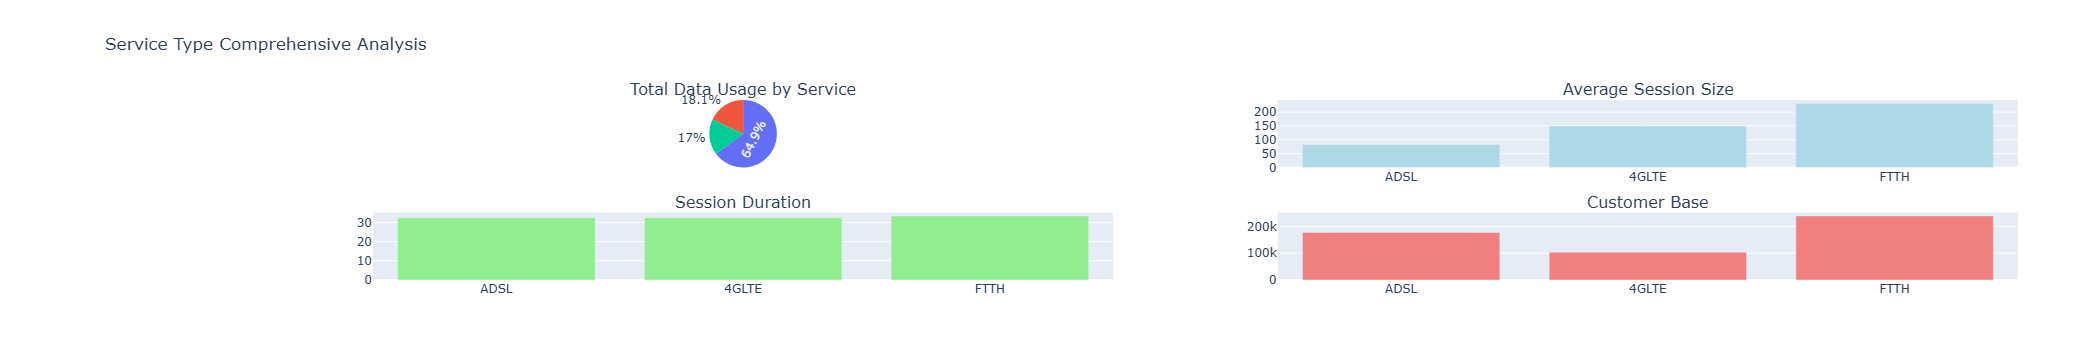

In [27]:
service_analysis = spark.sql("""
    SELECT 
        service_type,
        COUNT(*) as total_cdrs,
        COUNT(DISTINCT customer_id) as unique_customers,
        SUM(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE 0 END) / 1024 as total_data_gb,
        AVG(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE NULL END) as avg_session_mb,
        PERCENTILE_APPROX(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE NULL END, 0.5) as median_session_mb,
        MAX(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE 0 END) as max_session_mb,
        AVG(CASE WHEN cdr_type = 'DATA' THEN duration_minutes ELSE NULL END) as avg_duration_min
    FROM fact_cdr_raw
    GROUP BY service_type
""").toPandas()

print("📊 Service Type Performance:")
print(service_analysis.round(2))

# Create comprehensive service comparison
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Total Data Usage by Service', 'Average Session Size',
                    'Session Duration', 'Customer Base'),
    specs=[[{"type": "pie"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

# Total data usage pie
fig.add_trace(
    go.Pie(labels=service_analysis['service_type'], 
           values=service_analysis['total_data_gb'],
           name='Data Usage'),
    row=1, col=1
)

# Average session size
fig.add_trace(
    go.Bar(x=service_analysis['service_type'], 
           y=service_analysis['avg_session_mb'],
           name='Avg Session', marker_color='lightblue'),
    row=1, col=2
)

# Session duration
fig.add_trace(
    go.Bar(x=service_analysis['service_type'], 
           y=service_analysis['avg_duration_min'],
           name='Duration', marker_color='lightgreen'),
    row=2, col=1
)

# Customer base
fig.add_trace(
    go.Bar(x=service_analysis['service_type'], 
           y=service_analysis['unique_customers'],
           name='Customers', marker_color='lightcoral'),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False, 
                  title_text="Service Type Comprehensive Analysis")
fig.show()

## 7. Anomaly Detection Analysis
Anomaly patterns analysis

🚨 Anomaly Detection Summary:
           anomaly_type severity    count  affected_customers  \
0           USAGE_SPIKE   MEDIUM  3022021              518431   
1       UNUSUAL_PATTERN   MEDIUM  3016426              518243   
2           SUDDEN_DROP   MEDIUM  1513044              491502   
3            ZERO_USAGE   MEDIUM  1490491              487107   
4      IMPOSSIBLE_USAGE     HIGH   755002              398236   
5    BANDWIDTH_EXCEEDED   MEDIUM   677013               77959   
6  CONTINUOUS_MAX_USAGE     HIGH   172239               56768   

   avg_anomaly_volume  affected_wilayas  affected_days  
0        26048.687896                58            122  
1         1215.137390                58            122  
2            2.894191                58            122  
3            0.000000                58            122  
4         5200.881309                58            122  
5        16824.439117                58            122  
6        19616.550050                43            

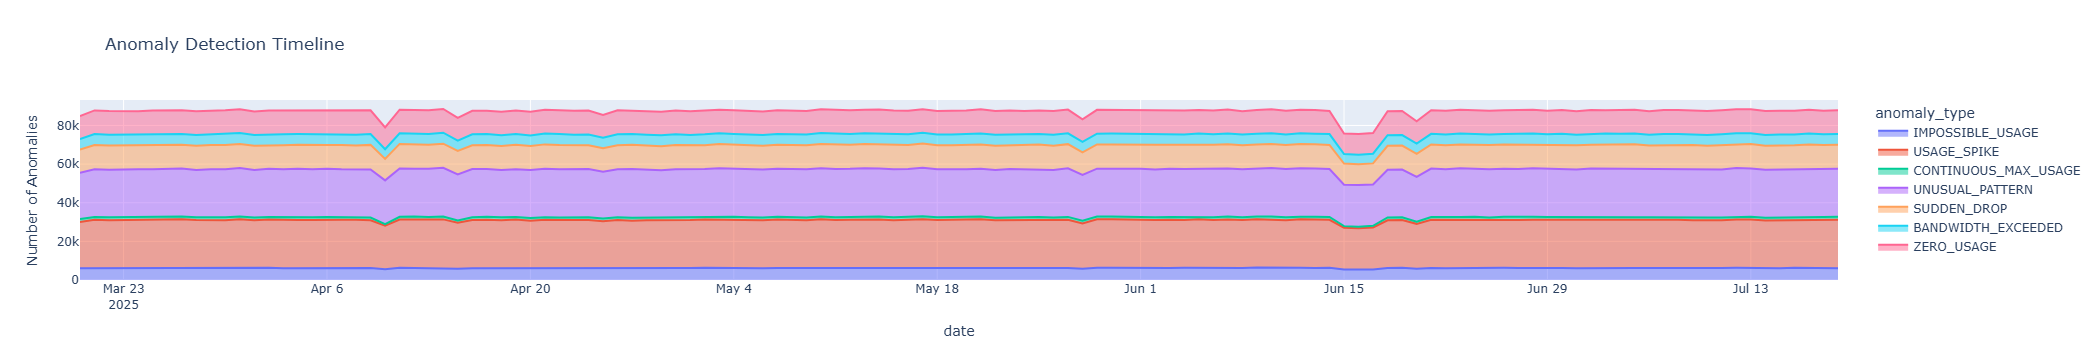


🎯 Analyzing top affected customers...



🎯 Top 10 Customers with Most Anomalies:
  16FTAB583D: 64 anomalies - FTTH/Fibre 100Mbps (PARTICULIER)
  07FT2E2F54: 60 anomalies - FTTH/Fibre 300Mbps (PARTICULIER)
  31FT04520C: 56 anomalies - FTTH/Fibre 100Mbps (PARTICULIER)
  32FT3FCA19: 56 anomalies - FTTH/Fibre 100Mbps Gamers (PARTICULIER)
  47FTC7292C: 55 anomalies - FTTH/Fibre 100Mbps Gamers (PARTICULIER)
  16FT80ABCD: 54 anomalies - FTTH/Fibre 15Mbps (PARTICULIER)
  04FT941D33: 54 anomalies - FTTH/Fibre 100Mbps Gamers (PARTICULIER)
  06FT9C9A16: 53 anomalies - FTTH/Fibre 500Mbps (PARTICULIER)
  46FT8DD266: 52 anomalies - FTTH/Fibre 500Mbps (PARTICULIER)
  27FT72F6BC: 52 anomalies - FTTH/Fibre 30Mbps (PARTICULIER)

📊 Creating anomaly distribution visualization...


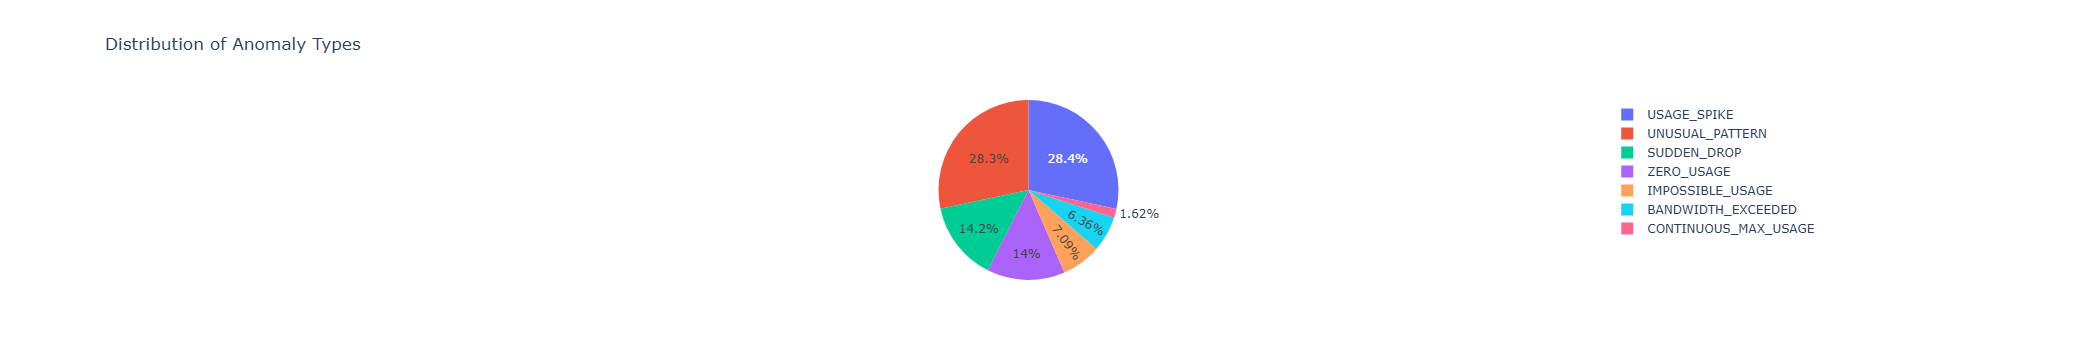

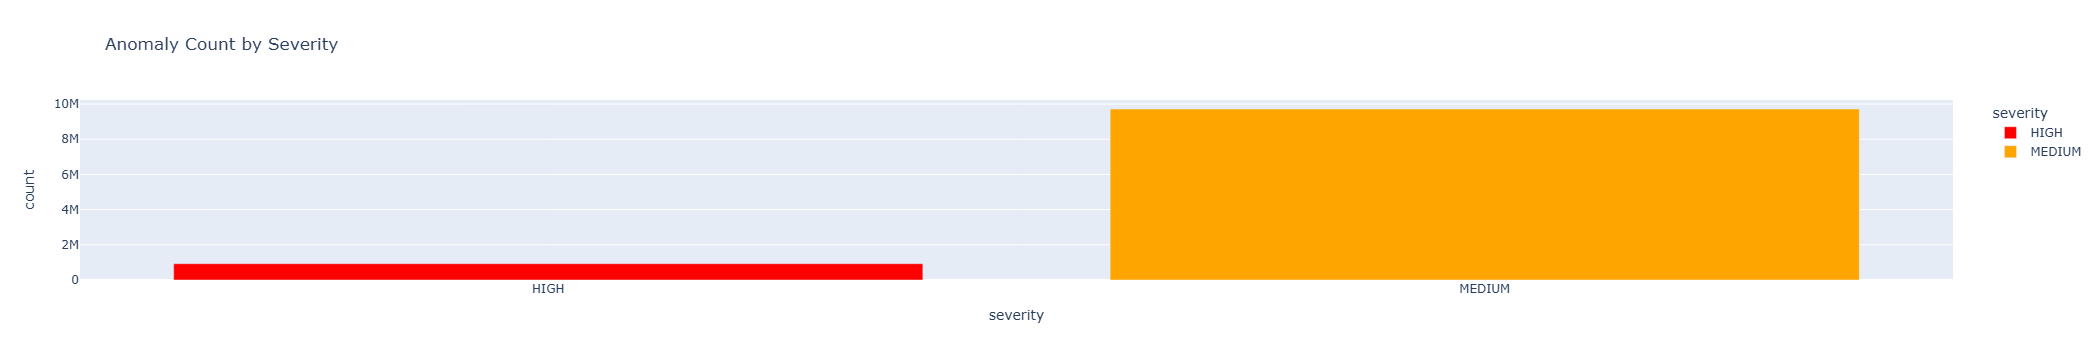


⏰ Analyzing anomaly patterns by hour...


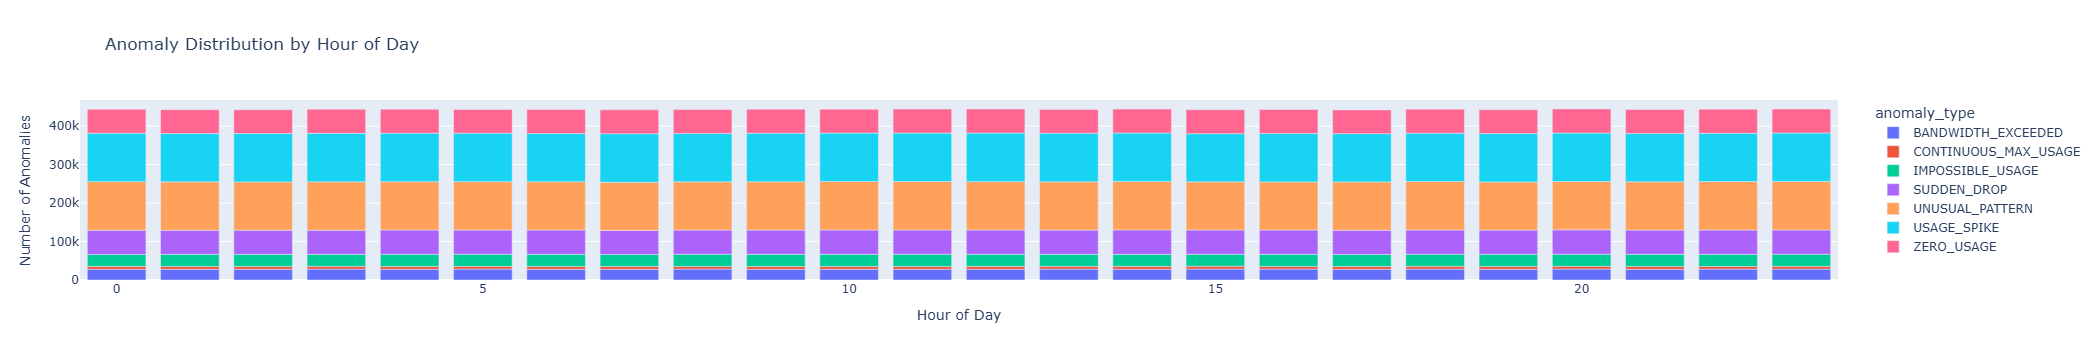


🔝 Top 5 Hours with Most Anomalies:
  Hour 20:00 - 444,661 anomalies
  Hour 23:00 - 444,566 anomalies
  Hour 12:00 - 444,501 anomalies
  Hour 14:00 - 444,465 anomalies
  Hour 11:00 - 444,428 anomalies

✅ Anomaly analysis complete!


In [32]:
# %% [markdown]
# ## Fixed Anomaly Detection Analysis

# %%
# Setup - Make sure temp views exist
if 'fact_cdr_raw' not in [t.name for t in spark.catalog.listTables()]:
    cdr_raw = spark.read.parquet("/user/hive/warehouse/Raw/raw_cdr_enhanced/")
    cdr_raw.createOrReplaceTempView("fact_cdr_raw")
    print("✅ Created fact_cdr_raw temp view")

# Also create dim_customers if needed
try:
    spark.sql("SELECT 1 FROM dim_customers LIMIT 1")
except:
    customers = spark.read.parquet("/user/hive/warehouse/Raw/customer_dim_enhanced/")
    customers.createOrReplaceTempView("dim_customers")
    print("✅ Created dim_customers temp view")

# %%
# Anomaly Detection Analysis
anomaly_analysis = spark.sql("""
    SELECT 
        anomaly_type,
        severity,
        COUNT(*) as count,
        COUNT(DISTINCT customer_id) as affected_customers,
        AVG(data_volume_mb) as avg_anomaly_volume,
        COUNT(DISTINCT wilaya_code) as affected_wilayas,
        COUNT(DISTINCT DATE(timestamp)) as affected_days
    FROM fact_cdr_raw
    WHERE cdr_type = 'ANOMALY'
    GROUP BY anomaly_type, severity
    ORDER BY count DESC
""").toPandas()

if len(anomaly_analysis) > 0:
    print("🚨 Anomaly Detection Summary:")
    print(anomaly_analysis)
    print(f"\nTotal Anomalies: {anomaly_analysis['count'].sum():,}")
    print(f"Total Affected Customers: {anomaly_analysis['affected_customers'].sum():,}")
    
    # Anomaly time distribution
    anomaly_timeline = spark.sql("""
        SELECT 
            DATE(timestamp) as date,
            anomaly_type,
            COUNT(*) as anomaly_count
        FROM fact_cdr_raw
        WHERE cdr_type = 'ANOMALY'
        GROUP BY DATE(timestamp), anomaly_type
        ORDER BY date
    """).toPandas()
    
    # Create anomaly visualization
    fig = px.area(anomaly_timeline, 
                  x='date', 
                  y='anomaly_count',
                  color='anomaly_type',
                  title='Anomaly Detection Timeline',
                  labels={'anomaly_count': 'Number of Anomalies'})
    fig.update_layout(height=500)
    fig.show()
    
    # Top affected customers - SIMPLIFIED VERSION WITHOUT COLLECT_SET
    print("\n🎯 Analyzing top affected customers...")
    
    # First get the top customers
    top_customers = spark.sql("""
        SELECT 
            customer_id,
            COUNT(*) as anomaly_count
        FROM fact_cdr_raw
        WHERE cdr_type = 'ANOMALY'
        GROUP BY customer_id
        ORDER BY anomaly_count DESC
        LIMIT 10
    """).collect()
    
    print("\n🎯 Top 10 Customers with Most Anomalies:")
    for row in top_customers:
        customer_id = row['customer_id']
        anomaly_count = row['anomaly_count']
        
        # Get customer details separately to avoid large join
        customer_info = spark.sql(f"""
            SELECT DISTINCT
                customer_type,
                service_type,
                offer_name
            FROM dim_customers
            WHERE customer_id = '{customer_id}'
            LIMIT 1
        """).collect()
        
        if customer_info:
            info = customer_info[0]
            print(f"  {customer_id}: {anomaly_count:,} anomalies - "
                  f"{info['service_type']}/{info['offer_name']} ({info['customer_type']})")
        else:
            print(f"  {customer_id}: {anomaly_count:,} anomalies")
    
    # Anomaly type distribution for visualization
    print("\n📊 Creating anomaly distribution visualization...")
    
    # Pie chart of anomaly types
    anomaly_dist = anomaly_analysis.groupby('anomaly_type')['count'].sum().reset_index()
    
    fig_pie = px.pie(anomaly_dist, 
                     values='count', 
                     names='anomaly_type',
                     title='Distribution of Anomaly Types')
    fig_pie.show()
    
    # Severity distribution
    severity_dist = anomaly_analysis.groupby('severity')['count'].sum().reset_index()
    
    fig_severity = px.bar(severity_dist, 
                          x='severity', 
                          y='count',
                          title='Anomaly Count by Severity',
                          color='severity',
                          color_discrete_map={'HIGH': 'red', 'MEDIUM': 'orange', 'LOW': 'yellow'})
    fig_severity.show()
    
else:
    print("✅ No anomalies found in the dataset")

# %%
# Additional analysis: Anomaly patterns by hour
print("\n⏰ Analyzing anomaly patterns by hour...")

hourly_anomalies = spark.sql("""
    SELECT 
        HOUR(timestamp) as hour,
        anomaly_type,
        COUNT(*) as count
    FROM fact_cdr_raw
    WHERE cdr_type = 'ANOMALY'
    GROUP BY HOUR(timestamp), anomaly_type
    ORDER BY hour, anomaly_type
""").toPandas()

if len(hourly_anomalies) > 0:
    # Pivot for better visualization
    hourly_pivot = hourly_anomalies.pivot(index='hour', 
                                          columns='anomaly_type', 
                                          values='count').fillna(0)
    
    # Create stacked bar chart
    fig_hourly = px.bar(hourly_anomalies, 
                        x='hour', 
                        y='count',
                        color='anomaly_type',
                        title='Anomaly Distribution by Hour of Day',
                        labels={'hour': 'Hour of Day', 'count': 'Number of Anomalies'})
    fig_hourly.update_layout(height=500)
    fig_hourly.show()
    
    # Find peak anomaly hours
    peak_hours = hourly_anomalies.groupby('hour')['count'].sum().nlargest(5)
    print("\n🔝 Top 5 Hours with Most Anomalies:")
    for hour, count in peak_hours.items():
        print(f"  Hour {hour:02d}:00 - {count:,} anomalies")

print("\n✅ Anomaly analysis complete!")

## 8. Outage Impact Analysis

🔌 Major Outage Events:
  outage_date wilaya_name   outage_type  affected_customers  \
0  2025-04-10       Alger  CYBER_ATTACK               28745   
1  2025-06-15       Alger      OVERLOAD               28745   
2  2025-06-16       Alger      OVERLOAD               28745   
3  2025-06-17       Alger      OVERLOAD               28745   
4  2025-06-20       Alger   MAINTENANCE               28745   
5  2025-04-10        Oran  CYBER_ATTACK               23000   
6  2025-04-15        Oran     FIBER_CUT               23000   
7  2025-06-15        Oran      OVERLOAD               23000   
8  2025-06-16        Oran      OVERLOAD               23000   
9  2025-06-17        Oran      OVERLOAD               23000   

   avg_duration_hours  total_loss_da max_impact  
0                0.25        1025.02   MODERATE  
1                2.00        8199.87   MODERATE  
2                2.00        8199.87   MODERATE  
3                2.00        8199.87   MODERATE  
4                2.00        8199

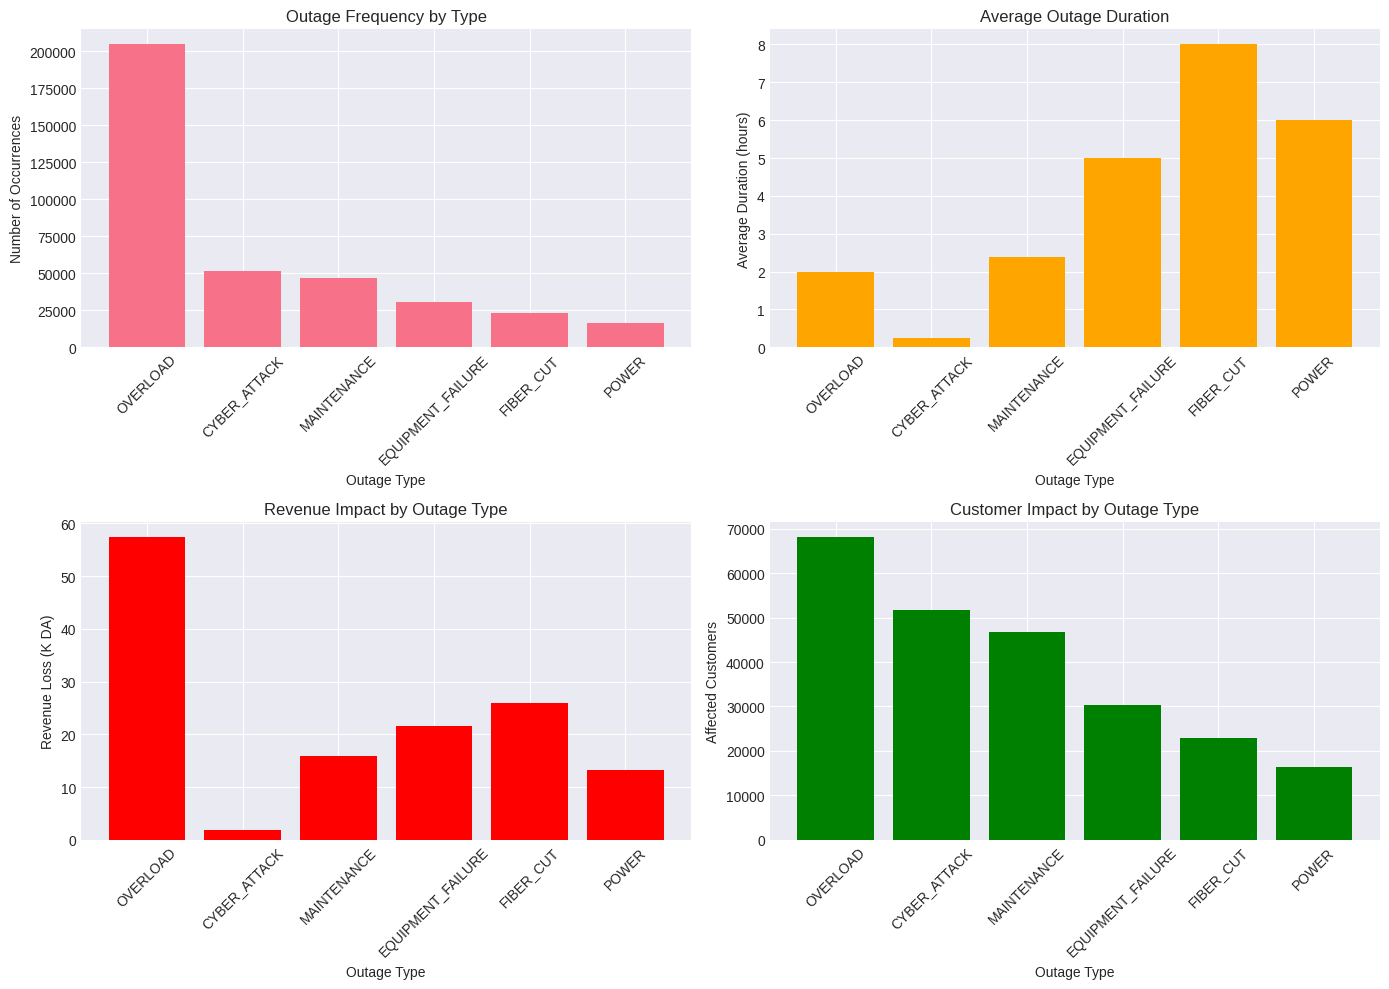

In [33]:
# Check if there are outages
outage_count = spark.sql("SELECT COUNT(*) FROM fact_cdr_raw WHERE cdr_type = 'OUTAGE'").collect()[0][0]

if outage_count > 0:
    outage_analysis = spark.sql("""
        SELECT 
            DATE(timestamp) as outage_date,
            wilaya_name,
            outage_type,
            COUNT(*) as affected_customers,
            AVG(outage_duration_hours) as avg_duration_hours,
            SUM(estimated_loss_da) as total_loss_da,
            MAX(impact_level) as max_impact
        FROM fact_cdr_raw
        WHERE cdr_type = 'OUTAGE'
        GROUP BY DATE(timestamp), wilaya_name, outage_type
        ORDER BY affected_customers DESC
    """).toPandas()
    
    print("🔌 Major Outage Events:")
    print(outage_analysis.head(10))
    
    # Outage type distribution
    outage_types = spark.sql("""
        SELECT 
            outage_type,
            COUNT(*) as occurrences,
            COUNT(DISTINCT customer_id) as affected_customers,
            AVG(outage_duration_hours) as avg_duration,
            SUM(estimated_loss_da) as total_revenue_loss
        FROM fact_cdr_raw
        WHERE cdr_type = 'OUTAGE'
        GROUP BY outage_type
        ORDER BY occurrences DESC
    """).toPandas()
    
    # Visualize outage impact
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Outage types frequency
    axes[0, 0].bar(outage_types['outage_type'], outage_types['occurrences'])
    axes[0, 0].set_xlabel('Outage Type')
    axes[0, 0].set_ylabel('Number of Occurrences')
    axes[0, 0].set_title('Outage Frequency by Type')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Average duration by type
    axes[0, 1].bar(outage_types['outage_type'], outage_types['avg_duration'], color='orange')
    axes[0, 1].set_xlabel('Outage Type')
    axes[0, 1].set_ylabel('Average Duration (hours)')
    axes[0, 1].set_title('Average Outage Duration')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Revenue loss
    axes[1, 0].bar(outage_types['outage_type'], outage_types['total_revenue_loss']/1000, color='red')
    axes[1, 0].set_xlabel('Outage Type')
    axes[1, 0].set_ylabel('Revenue Loss (K DA)')
    axes[1, 0].set_title('Revenue Impact by Outage Type')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Affected customers
    axes[1, 1].bar(outage_types['outage_type'], outage_types['affected_customers'], color='green')
    axes[1, 1].set_xlabel('Outage Type')
    axes[1, 1].set_ylabel('Affected Customers')
    axes[1, 1].set_title('Customer Impact by Outage Type')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("✅ No outages found in the dataset")

## 9. Usage Type and Session Quality Analysis

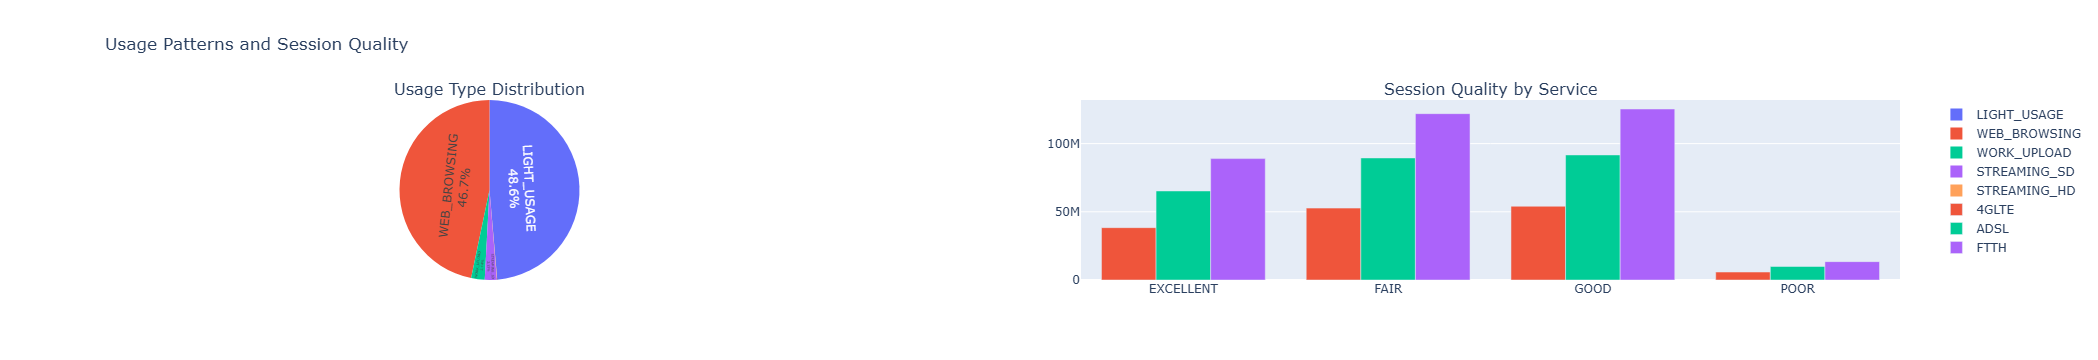

In [34]:
# Usage type distribution
usage_types = spark.sql("""
    SELECT 
        usage_type,
        COUNT(*) as session_count,
        AVG(data_volume_mb) as avg_data_mb,
        AVG(duration_minutes) as avg_duration,
        COUNT(DISTINCT customer_id) as unique_users
    FROM fact_cdr_raw
    WHERE cdr_type = 'DATA' AND usage_type IS NOT NULL
    GROUP BY usage_type
    ORDER BY session_count DESC
""").toPandas()

# Session quality analysis
session_quality = spark.sql("""
    SELECT 
        session_quality,
        service_type,
        COUNT(*) as sessions,
        AVG(data_volume_mb) as avg_data_mb,
        AVG(duration_minutes) as avg_duration
    FROM fact_cdr_raw
    WHERE cdr_type = 'DATA' AND session_quality IS NOT NULL
    GROUP BY session_quality, service_type
    ORDER BY sessions DESC
""").toPandas()

if len(usage_types) > 0 and len(session_quality) > 0:
    # Create usage pattern visualization
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Usage Type Distribution', 'Session Quality by Service'),
        specs=[[{"type": "pie"}, {"type": "bar"}]]
    )
    
    # Usage type pie chart
    fig.add_trace(
        go.Pie(labels=usage_types['usage_type'], 
               values=usage_types['session_count'],
               textposition='inside',
               textinfo='percent+label'),
        row=1, col=1
    )
    
    # Session quality grouped bar
    quality_pivot = session_quality.pivot(index='session_quality', 
                                         columns='service_type', 
                                         values='sessions').fillna(0)
    
    for service in quality_pivot.columns:
        fig.add_trace(
            go.Bar(name=service, 
                   x=quality_pivot.index, 
                   y=quality_pivot[service]),
            row=1, col=2
        )
    
    fig.update_layout(height=500, title_text="Usage Patterns and Session Quality")
    fig.show()
else:
    print("ℹ️ No usage type or session quality data available")


## 10. Customer Behavior Patterns

👥 Customer Usage Categories:
  user_category  customer_count  avg_total_data_mb  avg_sessions  \
0    Light User           16893       31083.243635   1230.730066   
1    Heavy User          387888      298145.917140   1523.097925   
2   Medium User          115131       75192.841468   1265.005889   

   avg_active_days  
0       121.386610  
1       121.176577  
2       121.296080  


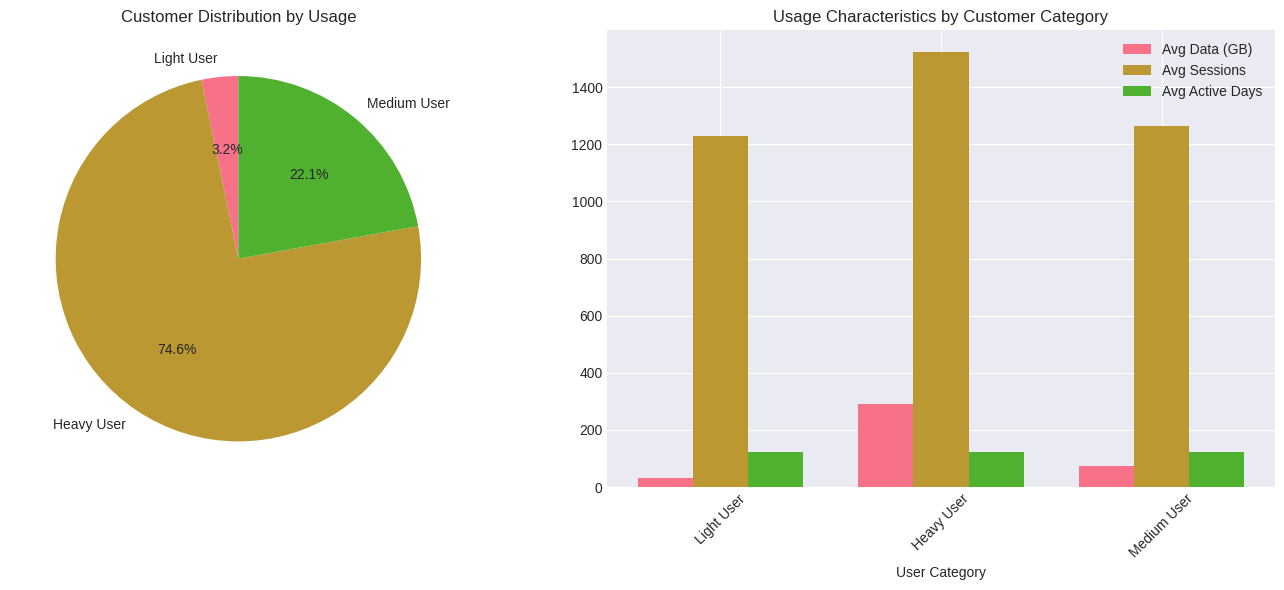


✅ Analysis Complete!


In [35]:
# Analyze customer usage patterns
customer_patterns = spark.sql("""
    WITH customer_metrics AS (
        SELECT 
            customer_id,
            COUNT(*) as total_sessions,
            SUM(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE 0 END) as total_data_mb,
            AVG(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE NULL END) as avg_session_mb,
            COUNT(DISTINCT DATE(timestamp)) as active_days,
            COUNT(DISTINCT HOUR(timestamp)) as active_hours,
            MAX(CASE WHEN HOUR(timestamp) BETWEEN 0 AND 5 THEN 1 ELSE 0 END) as night_user,
            MAX(CASE WHEN HOUR(timestamp) BETWEEN 9 AND 17 THEN 1 ELSE 0 END) as business_user,
            MAX(CASE WHEN HOUR(timestamp) BETWEEN 20 AND 23 THEN 1 ELSE 0 END) as evening_user
        FROM fact_cdr_raw
        WHERE cdr_type = 'DATA'
        GROUP BY customer_id
    )
    SELECT 
        CASE 
            WHEN total_data_mb > 100000 THEN 'Heavy User'
            WHEN total_data_mb > 50000 THEN 'Medium User'
            WHEN total_data_mb > 10000 THEN 'Light User'
            ELSE 'Very Light User'
        END as user_category,
        COUNT(*) as customer_count,
        AVG(total_data_mb) as avg_total_data_mb,
        AVG(total_sessions) as avg_sessions,
        AVG(active_days) as avg_active_days
    FROM customer_metrics
    GROUP BY 
        CASE 
            WHEN total_data_mb > 100000 THEN 'Heavy User'
            WHEN total_data_mb > 50000 THEN 'Medium User'
            WHEN total_data_mb > 10000 THEN 'Light User'
            ELSE 'Very Light User'
        END
""").toPandas()

print("👥 Customer Usage Categories:")
print(customer_patterns)

# Visualize customer patterns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Customer distribution
ax1.pie(customer_patterns['customer_count'], 
        labels=customer_patterns['user_category'],
        autopct='%1.1f%%',
        startangle=90)
ax1.set_title('Customer Distribution by Usage')

# Usage characteristics
x = np.arange(len(customer_patterns))
width = 0.25

ax2.bar(x - width, customer_patterns['avg_total_data_mb']/1024, width, label='Avg Data (GB)')
ax2.bar(x, customer_patterns['avg_sessions'], width, label='Avg Sessions')
ax2.bar(x + width, customer_patterns['avg_active_days'], width, label='Avg Active Days')

ax2.set_xlabel('User Category')
ax2.set_xticks(x)
ax2.set_xticklabels(customer_patterns['user_category'], rotation=45)
ax2.legend()
ax2.set_title('Usage Characteristics by Customer Category')

plt.tight_layout()
plt.show()

print("\n✅ Analysis Complete!")

## 11. Weekend vs Weekday Analysis

🏷  Vérification de la table fact_cdr_raw...
✅ Table fact_cdr_raw détectée.

⏳ Extraction des stats Weekend vs Weekday depuis fact_cdr_raw...


🔢 Calcul de l'erreur type et IC 95%...
📊 Génération du graphique Weekend vs Weekday...


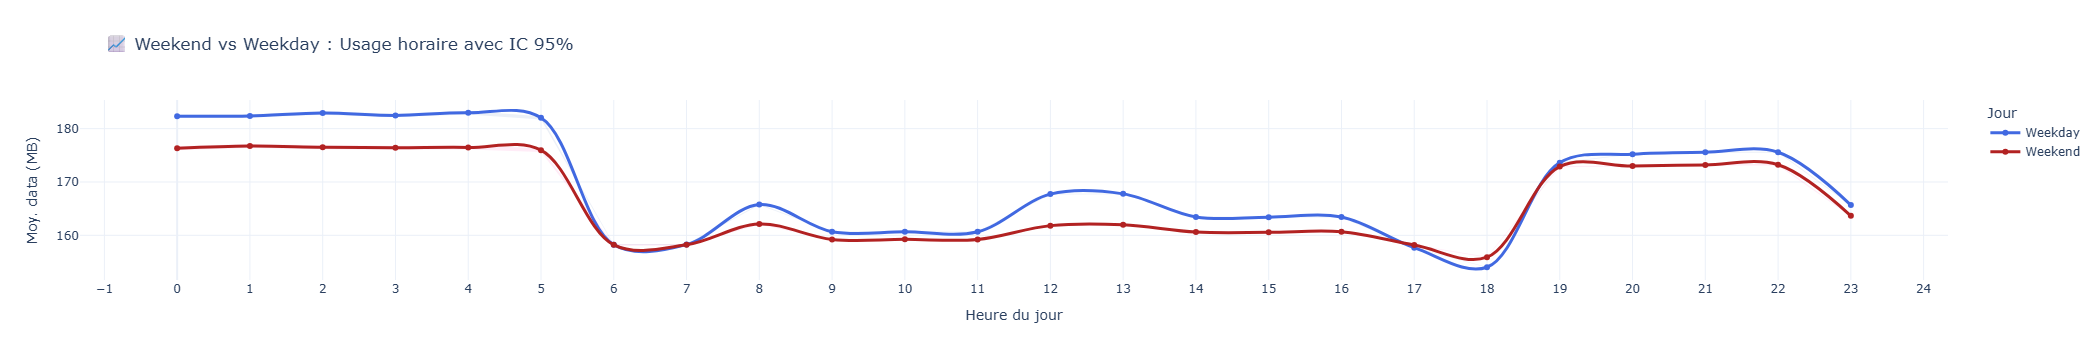


✅ Analyse Weekend vs Weekday terminée avec succès !


In [40]:
import numpy as np
import plotly.graph_objects as go

# --- 0) Ensure the raw table/view exists ---
print("🏷  Vérification de la table fact_cdr_raw...")
if not spark.catalog.tableExists("fact_cdr_raw"):
    raise RuntimeError("❌ La table fact_cdr_raw est introuvable. Veuillez vérifier le nom de la vue.")
print("✅ Table fact_cdr_raw détectée.\n")

# --- 1) Pull & aggregate weekend vs weekday stats ---
print("⏳ Extraction des stats Weekend vs Weekday depuis fact_cdr_raw...")
weekend_stats = spark.sql("""
SELECT
  CASE WHEN DAYOFWEEK(timestamp) IN (6,7) THEN 'Weekend' ELSE 'Weekday' END AS day_type,
  HOUR(timestamp)                                                   AS hour,
  AVG(CASE WHEN cdr_type='DATA' THEN data_volume_mb END)            AS avg_data_mb,
  STDDEV_POP(CASE WHEN cdr_type='DATA' THEN data_volume_mb END)     AS stddev_data_mb,
  COUNT(CASE WHEN cdr_type='DATA' THEN 1 END)                       AS data_sessions
FROM fact_cdr_raw
GROUP BY 1,2
ORDER BY 1,2
""").toPandas()

# --- 2) Abort if no data ---
if weekend_stats.empty:
    print("ℹ️ Aucun enregistrement DATA dans fact_cdr_raw—analyse Weekend vs Weekday annulée.")
else:
    # 3) Compute SE & 95% CI
    print("🔢 Calcul de l'erreur type et IC 95%...")
    weekend_stats['stderr']   = weekend_stats['stddev_data_mb'] / np.sqrt(weekend_stats['data_sessions'])
    weekend_stats['ci_upper'] = weekend_stats['avg_data_mb'] + 1.96 * weekend_stats['stderr']
    weekend_stats['ci_lower'] = weekend_stats['avg_data_mb'] - 1.96 * weekend_stats['stderr']

    # 4) Build Plotly figure
    print("📊 Génération du graphique Weekend vs Weekday...")
    colors = {'Weekday':'royalblue','Weekend':'firebrick'}
    fig = go.Figure()

    for day, col in colors.items():
        df = weekend_stats[weekend_stats['day_type']==day]

        # 4a) Shaded band for CI
        fig.add_trace(go.Scatter(
            x=np.concatenate([df.hour, df.hour[::-1]]),
            y=np.concatenate([df.ci_upper, df.ci_lower[::-1]]),
            fill='toself',
            fillcolor=f'rgba({255 if day=="Weekend" else 65},{65 if day=="Weekend" else 105},180,0.1)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo='skip',
            showlegend=False
        ))

        # 4b) Spline line + markers
        fig.add_trace(go.Scatter(
            name=day,
            x=df.hour,
            y=df.avg_data_mb,
            mode='lines+markers',
            line=dict(color=col, shape='spline', width=3),
            marker=dict(size=6),
            customdata=np.vstack([df.ci_lower, df.ci_upper]).T,
            hovertemplate=(
                "<b>%{name}</b><br>"
                "Heure : %{x}h<br>"
                "Moyenne : %{y:.1f} MB<br>"
                "IC 95% : [%{customdata[0]:.1f} – %{customdata[1]:.1f}]"
            )
        ))

    # 5) Layout tweaks
    fig.update_layout(
        title="📈 Weekend vs Weekday : Usage horaire avec IC 95%",
        xaxis=dict(title='Heure du jour', tickmode='linear', dtick=1),
        yaxis=dict(title='Moy. data (MB)'),
        hovermode='x unified',
        legend_title='Jour',
        template='plotly_white',
        height=500
    )

    fig.show()
    print("\n✅ Analyse Weekend vs Weekday terminée avec succès !")


## 12. Special Events Impact Analysis

🔍 Vérification de la table fact_cdr_raw…
✅ Table fact_cdr_raw OK.

⏳ Extraction des métriques journalières (CDRs, DATA, utilisateurs)…


🔢 Agrégation par type d’événement…
🎉 Synthèse des impacts :



,event_type,days_count,mean_cdrs,std_cdrs,mean_data,std_data,mean_users,std_users,pct_change_cdrs
3,Normal Day,103,6214770.7,643247.6,985683.9,98803.3,519643.3,1326.2,0.0
4,Ramadan,10,7602533.1,93152.2,1211959.9,13850.2,519909.4,6.7,22.3
2,Eid el Fitr,3,7701912.7,718.8,1227756.4,238.3,519912.0,0.0,23.9
1,Baccalaureate,5,4274986.2,245945.5,668511.3,50600.1,519009.0,843.0,-31.2
0,Bac Results,1,7732002.0,NaN,1232784.4,NaN,519912.0,NaN,24.4



📊 Génération du graphique d’impact…


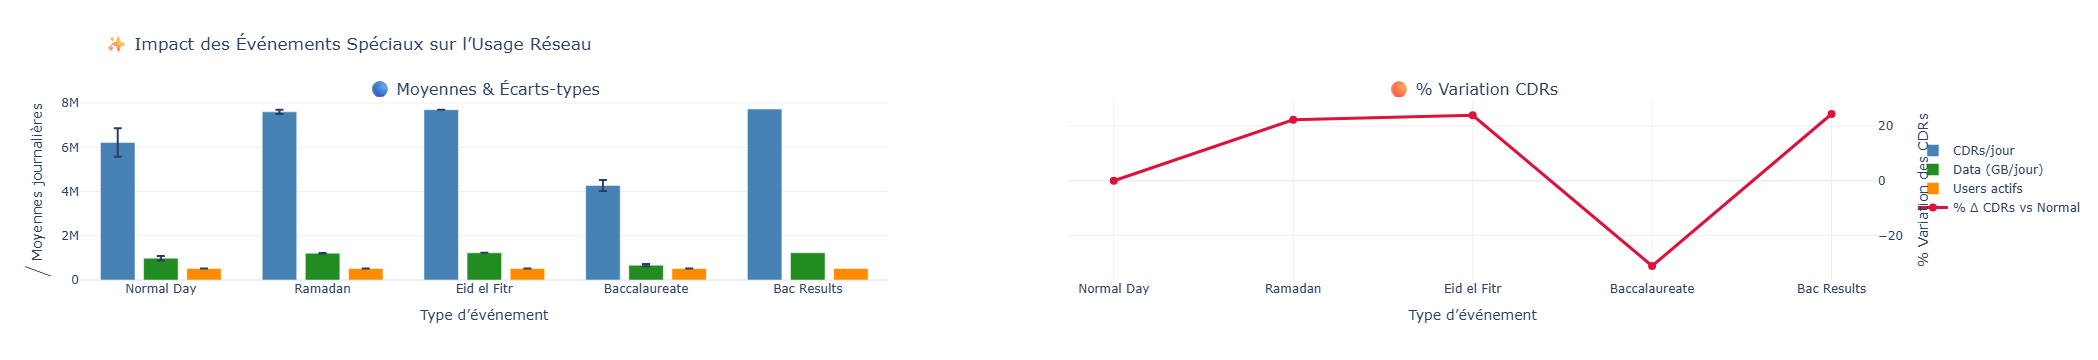


✅ Cell 12 – Impact des événements terminé !


In [41]:
# --------------------------------------------------------------------------------
# Cell 12 – Special Events Impact Analysis
# --------------------------------------------------------------------------------

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 0) Vérif. que fact_cdr_raw existe
print("🔍 Vérification de la table fact_cdr_raw…")
if not spark.catalog.tableExists("fact_cdr_raw"):
    raise RuntimeError("❌ Table/Vue fact_cdr_raw introuvable ! Abandon.")
print("✅ Table fact_cdr_raw OK.\n")

# 1) Extraction journalière & classification des événements
print("⏳ Extraction des métriques journalières (CDRs, DATA, utilisateurs)…")
daily_events = spark.sql("""
SELECT
  DATE(timestamp) AS date,
  CASE
    WHEN DATE(timestamp) BETWEEN '2025-03-20' AND '2025-03-29' THEN 'Ramadan'
    WHEN DATE(timestamp) BETWEEN '2025-03-31' AND '2025-04-02' THEN 'Eid el Fitr'
    WHEN DATE(timestamp) BETWEEN '2025-06-15' AND '2025-06-19' THEN 'Baccalaureate'
    WHEN DATE(timestamp) =       '2025-07-19'                  THEN 'Bac Results'
    ELSE 'Normal Day'
  END AS event_type,
  COUNT(*)                                    AS total_cdrs,
  ROUND(SUM(CASE WHEN cdr_type='DATA' THEN data_volume_mb ELSE 0 END)/1024, 1)  AS total_data_gb,
  COUNT(DISTINCT customer_id)                  AS active_users
FROM fact_cdr_raw
GROUP BY 1,2
ORDER BY 1
""").toPandas()

# 2) Cas “pas de données”
if daily_events.empty:
    print("ℹ️ Aucune ligne DATA dans fact_cdr_raw : pas d’analyse disponible.")
else:
    # 3) Synthèse par type d’événement
    print("🔢 Agrégation par type d’événement…")
    summary = (daily_events
        .groupby('event_type')
        .agg(
            days_count     = ('date',          'nunique'),
            mean_cdrs      = ('total_cdrs',    'mean'),
            std_cdrs       = ('total_cdrs',    'std'),
            mean_data      = ('total_data_gb', 'mean'),
            std_data       = ('total_data_gb', 'std'),
            mean_users     = ('active_users',  'mean'),
            std_users      = ('active_users',  'std')
        )
        .round(1)
        .reset_index()
    )

    # 4) Calcul du % de variation vs "Normal Day"
    normal = summary.loc[summary.event_type=='Normal Day', 'mean_cdrs'].iloc[0]
    summary['pct_change_cdrs'] = ((summary['mean_cdrs'] / normal) - 1) * 100
    summary['pct_change_cdrs'] = summary['pct_change_cdrs'].round(1)

    # 5) Réordonnancement logique
    order = ['Normal Day','Ramadan','Eid el Fitr','Baccalaureate','Bac Results']
    summary['event_type'] = pd.Categorical(summary['event_type'], categories=order, ordered=True)
    summary = summary.sort_values('event_type')

    # 6) Affichage synthétique
    print("🎉 Synthèse des impacts :\n")
    display(summary)

    # 7) Visualisation interactive Plotly
    print("\n📊 Génération du graphique d’impact…")
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('🔵 Moyennes & Écarts-types', '🟠 % Variation CDRs'),
        specs=[[{"type":"bar"},{"type":"scatter"}]]
    )

    # 7a) Barres : mean_cdrs ± std_cdrs, mean_data ± std_data, mean_users ± std_users
    fig.add_trace(go.Bar(
        x=summary.event_type, y=summary.mean_cdrs, name='CDRs/jour',
        error_y=dict(type='data', array=summary.std_cdrs),
        marker_color='steelblue'
    ), row=1, col=1)
    fig.add_trace(go.Bar(
        x=summary.event_type, y=summary.mean_data, name='Data (GB/jour)',
        error_y=dict(type='data', array=summary.std_data),
        marker_color='forestgreen'
    ), row=1, col=1)
    fig.add_trace(go.Bar(
        x=summary.event_type, y=summary.mean_users, name='Users actifs',
        error_y=dict(type='data', array=summary.std_users),
        marker_color='darkorange'
    ), row=1, col=1)

    # 7b) Ligne : % de variation des CDRs
    fig.add_trace(go.Scatter(
        x=summary.event_type, y=summary.pct_change_cdrs, name='% Δ CDRs vs Normal',
        mode='lines+markers', line=dict(color='crimson', width=3),
        marker=dict(size=8), yaxis='y2'
    ), row=1, col=2)

    # 8) Mise en page
    fig.update_layout(
        title="✨ Impact des Événements Spéciaux sur l’Usage Réseau",
        template='plotly_white',
        height=450,
        legend=dict(x=1.02, y=0.8),
        bargroupgap=0.2
    )
    # Ajout d'un deuxième axe Y sur le 2ᵉ plot
    fig.update_layout(
        yaxis2=dict(
            title='% Variation des CDRs',
            overlaying='y', side='right'
        ),
        xaxis2=dict(title='Type d’événement')
    )
    # Titres axes
    fig.update_xaxes(title='Type d’événement', row=1, col=1)
    fig.update_yaxes(title='⧸ Moyennes journalières', row=1, col=1)

    fig.show()

    print("\n✅ Cell 12 – Impact des événements terminé !")


## 13. Generate CDR Insights Report

In [43]:
import json
from datetime import datetime

# --------------------------------------------------------------------------------
# Cell 13 – Auto-discover & summarize ALL temp‐views
# --------------------------------------------------------------------------------
print("🔍 Discovery des vues temporaires dans spark.catalog…")
all_views = [
    t.name 
    for t in spark.catalog.listTables("algerie_telecom_cdr") 
    if t.isTemporary
]
print(f"✅ Trouvées {len(all_views)} vues temporaires.")

view_summaries = {}
for v in sorted(all_views):
    try:
        sdf = spark.table(v)
        pdf = sdf.limit(100000).toPandas()  # fetch up to 100k rows just for schema + date
    except Exception as e:
        view_summaries[v] = {"error": str(e)}
        continue

    summary = {
        "row_count"     : int(sdf.count()),
        "col_count"     : len(pdf.columns),
        "columns"       : pdf.columns.tolist(),
    }

    # if it has a timestamp column, extract range
    for ts_col in ("timestamp","date","day","hour"):
        if ts_col in pdf.columns:
            try:
                rng = sdf.selectExpr(
                    f"min({ts_col}) as mn",
                    f"max({ts_col}) as mx"
                ).toPandas().iloc[0]
                summary["min_"+ts_col] = str(rng["mn"])
                summary["max_"+ts_col] = str(rng["mx"])
            except:
                pass
            break

    view_summaries[v] = summary

report = {
    "generated_at": datetime.utcnow().isoformat()+"Z",
    "view_summaries": view_summaries
}

# pretty-print to console
print("\n" + "="*60)
print("📝 CDR VIEWS SUMMARY")
print("="*60)
for name, info in report["view_summaries"].items():
    print(f"\n• {name}")
    if "error" in info:
        print("    ❌ could not load:", info["error"])
        continue
    print(f"    rows: {info['row_count']:,}")
    print(f"    cols: {info['col_count']}  {info['columns']}")
    if "min_timestamp" in info:
        print(f"    ts  : {info['min_timestamp']} → {info['max_timestamp']}")
    elif "min_date" in info:
        print(f"    date: {info['min_date']} → {info['max_date']}")

# save to disk
with open("cdr_all_views_summary.json", "w") as f:
    json.dump(report, f, indent=2, default=str)
print("\n✅ Report saved to cdr_all_views_summary.json")


🔍 Discovery des vues temporaires dans spark.catalog…
✅ Trouvées 2 vues temporaires.

📝 CDR VIEWS SUMMARY

• dim_customers
    ❌ could not load: An error occurred while calling o943.collectToPython.
: org.apache.spark.SparkException: [INTERNAL_ERROR] The "collectToPython" action failed. You hit a bug in Spark or the Spark plugins you use. Please, report this bug to the corresponding communities or vendors, and provide the full stack trace.
	at org.apache.spark.SparkException$.internalError(SparkException.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$.toInternalError(QueryExecution.scala:536)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:548)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spar

## 14. Export Key Datasets for Visualization

In [4]:
# --------------------------------------------------------------------------------
# Cell 14 – Build & Export Key Datasets as Parquet + Report
# --------------------------------------------------------------------------------
import os, json
from datetime import datetime

# 0) (Re)Create the two temp-views from fact_cdr_raw
print("🔃 (Re)création des vues daily_summary & hourly_heatmap…")
spark.sql("""
  CREATE OR REPLACE TEMPORARY VIEW daily_summary AS
  SELECT
    DATE(timestamp) AS date,
    COUNT(*)                             AS total_cdrs,
    COUNT(DISTINCT customer_id)          AS unique_customers,
    SUM(CASE WHEN cdr_type='DATA' THEN data_volume_mb ELSE 0 END)/1024
                                         AS data_gb,
    AVG(CASE WHEN cdr_type='DATA' THEN data_volume_mb END)
                                         AS avg_session_mb,
    COUNT(CASE WHEN cdr_type='ANOMALY' THEN 1 END)
                                         AS anomalies,
    COUNT(CASE WHEN cdr_type='OUTAGE' THEN 1 END)
                                         AS outages
  FROM fact_cdr_raw
  GROUP BY DATE(timestamp)
""")
spark.sql("""
  CREATE OR REPLACE TEMPORARY VIEW hourly_heatmap AS
  SELECT
    DAYOFWEEK(timestamp)               AS day_of_week,
    HOUR(timestamp)                    AS hour,
    AVG(CASE WHEN cdr_type='DATA' THEN data_volume_mb ELSE 0 END)
                                       AS avg_data_mb
  FROM fact_cdr_raw
  GROUP BY DAYOFWEEK(timestamp), HOUR(timestamp)
""")
print("✅ Vues recréées.\n")

# 1) Read back into Spark DataFrames
print("⏳ Chargement des temp-views…")
df_daily  = spark.table("daily_summary")
df_hourly = spark.table("hourly_heatmap")
print(f"    • daily_summary : {df_daily.count():,} lignes")
print(f"    • hourly_heatmap: {df_hourly.count():,} lignes\n")

# 2) Ensure output directory exists
out_dir = "/mnt/data"
print(f"📁 Vérification du dossier {out_dir}…")
os.makedirs(out_dir, exist_ok=True)
print("✅ Dossier OK.\n")

# 3) Write out to Parquet
pq_daily  = f"{out_dir}/daily_summary.parquet"
pq_hourly = f"{out_dir}/hourly_heatmap.parquet"
print("💾 Écriture en Parquet…")
df_daily .write.mode("overwrite").parquet(pq_daily)
df_hourly.write.mode("overwrite").parquet(pq_hourly)
print(f"    • daily_summary → {pq_daily}")
print(f"    • hourly_heatmap → {pq_hourly}\n")

# 4) Build a small JSON report
report = {
  "generated_at": datetime.utcnow().isoformat() + "Z",
  "parquet_files": {
    "daily_summary":  pq_daily,
    "hourly_heatmap": pq_hourly
  },
  "counts": {
    "daily_records":  df_daily.count(),
    "hourly_records": df_hourly.count()
  },
  "note": (
    "📊 Parquet est préféré pour Power BI & Superset : "
    "colonne-orienté, schéma embarqué, compression, et "
    "requêtes plus rapides."
  )
}
out_json = f"{out_dir}/cdr_export_report.json"
print("🔧 Construction et sauvegarde du rapport JSON…")
with open(out_json, "w", encoding="utf8") as f:
    json.dump(report, f, indent=2, ensure_ascii=False)
print("✅ Rapport JSON →", out_json)

# 5) Final summary
print("\n🚀 Export terminé ! Parquet + résumé JSON prêts.")


🔃 (Re)création des vues daily_summary & hourly_heatmap…
✅ Vues recréées.

⏳ Chargement des temp-views…


    • daily_summary : 122 lignes


    • hourly_heatmap: 168 lignes

📁 Vérification du dossier /mnt/data…
✅ Dossier OK.

💾 Écriture en Parquet…


    • daily_summary → /mnt/data/daily_summary.parquet
    • hourly_heatmap → /mnt/data/hourly_heatmap.parquet



🔧 Construction et sauvegarde du rapport JSON…
✅ Rapport JSON → /mnt/data/cdr_export_report.json

🚀 Export terminé ! Parquet + résumé JSON prêts.


25/07/08 04:00:53 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
25/07/08 04:00:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exiting due to error from cluster scheduler: Master removed our application: KILLED
	at org.apache.spark.errors.SparkCoreErrors$.clusterSchedulerError(SparkCoreErrors.scala:291)
	at org.apache.spark.scheduler.TaskSchedulerImpl.error(TaskSchedulerImpl.scala:981)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.dead(StandaloneSchedulerBackend.scala:165)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint.markDead(StandaloneAppClient.scala:263)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anonfun$receive$1.applyOrElse(StandaloneAppClient.scala:170)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.proce